/tmp/ipykernel_6730/3285914437.py:69: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv(csv_path, encoding="latin1")


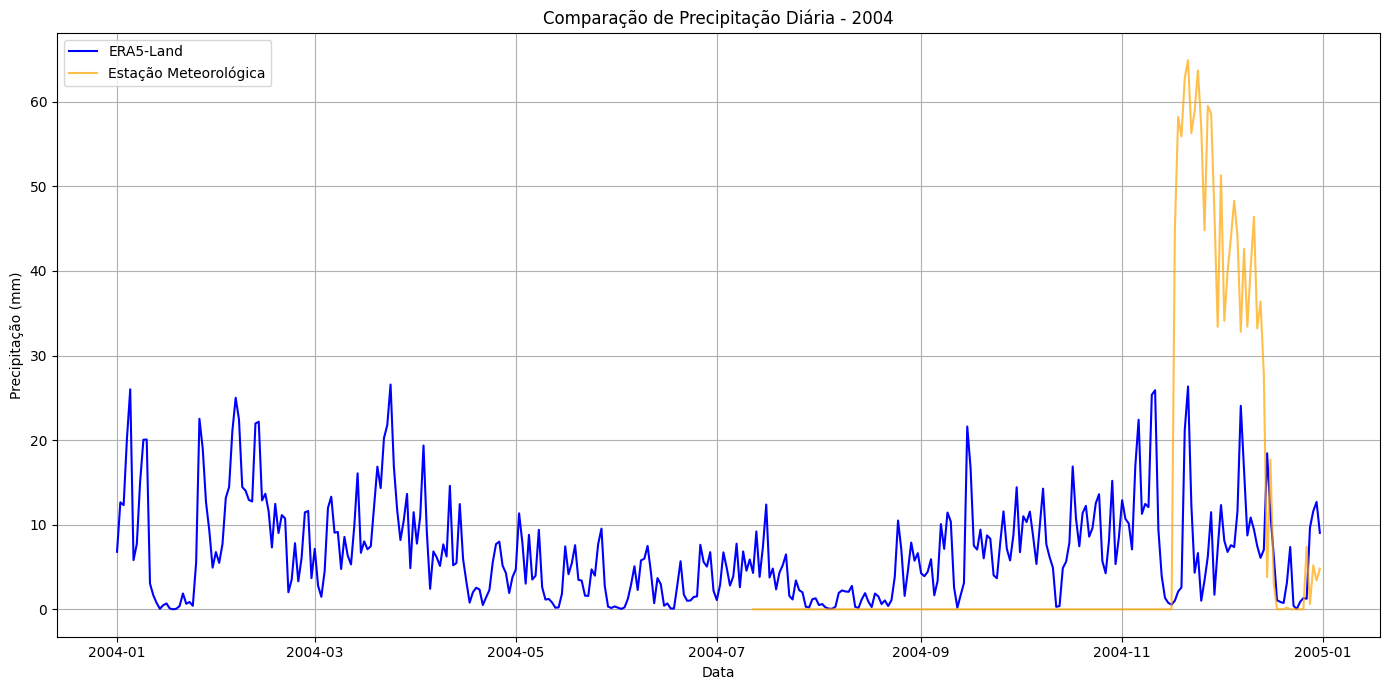

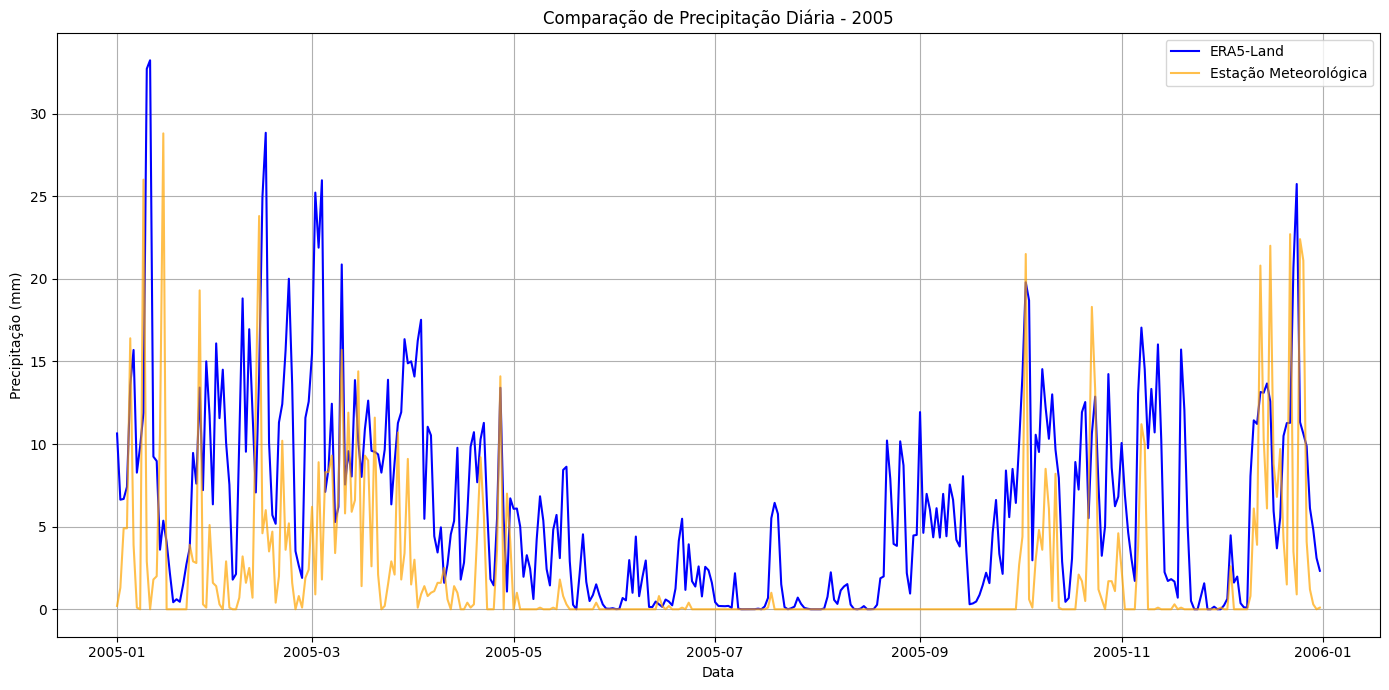

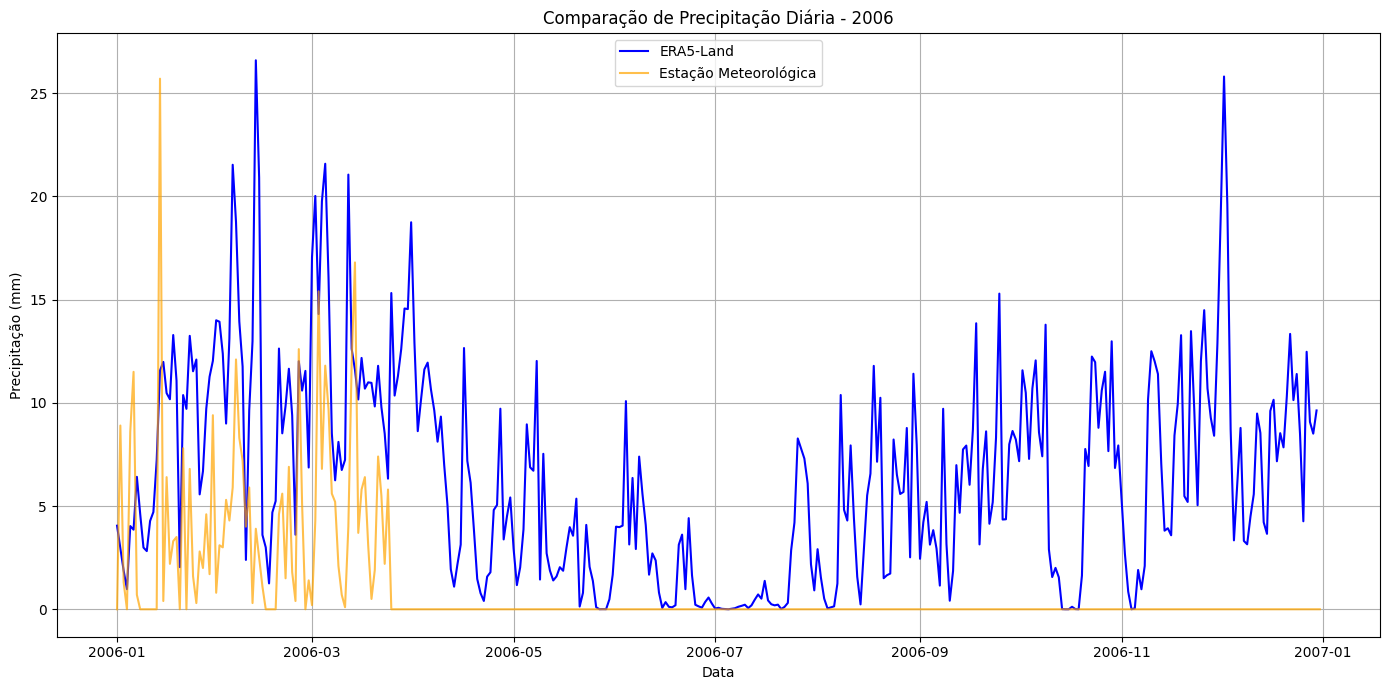

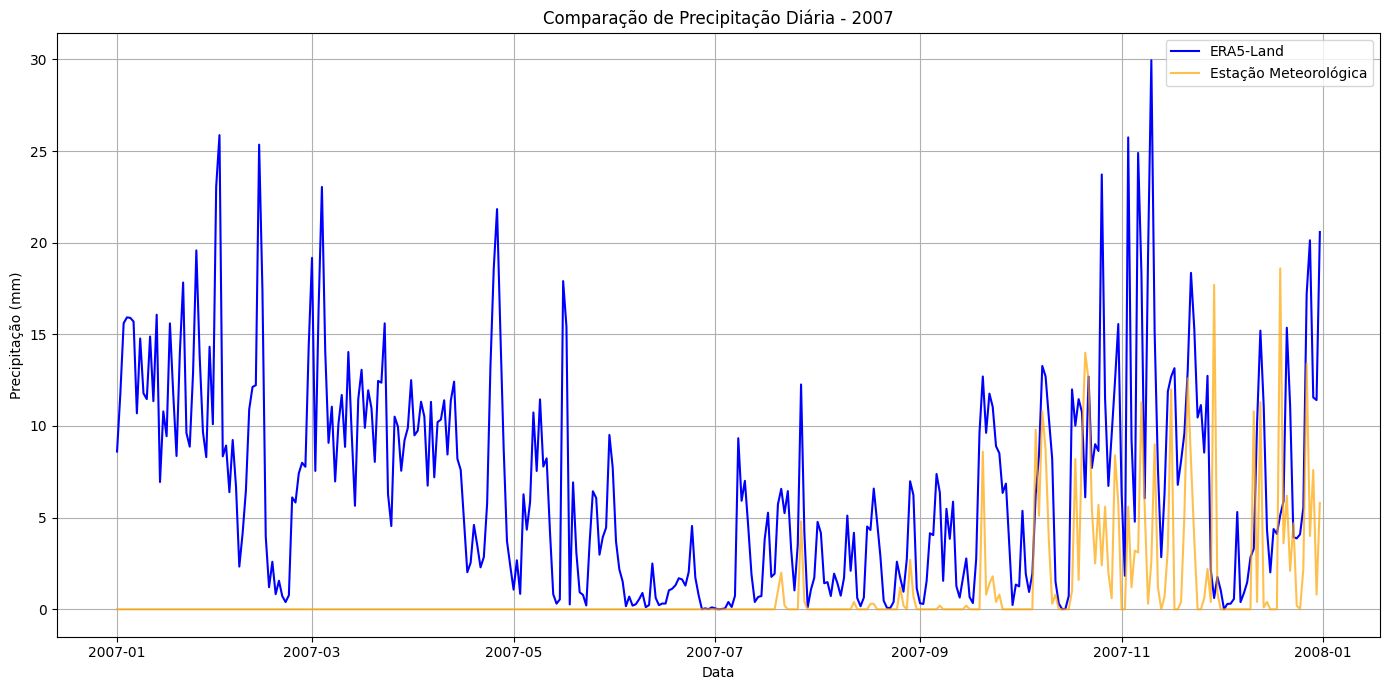

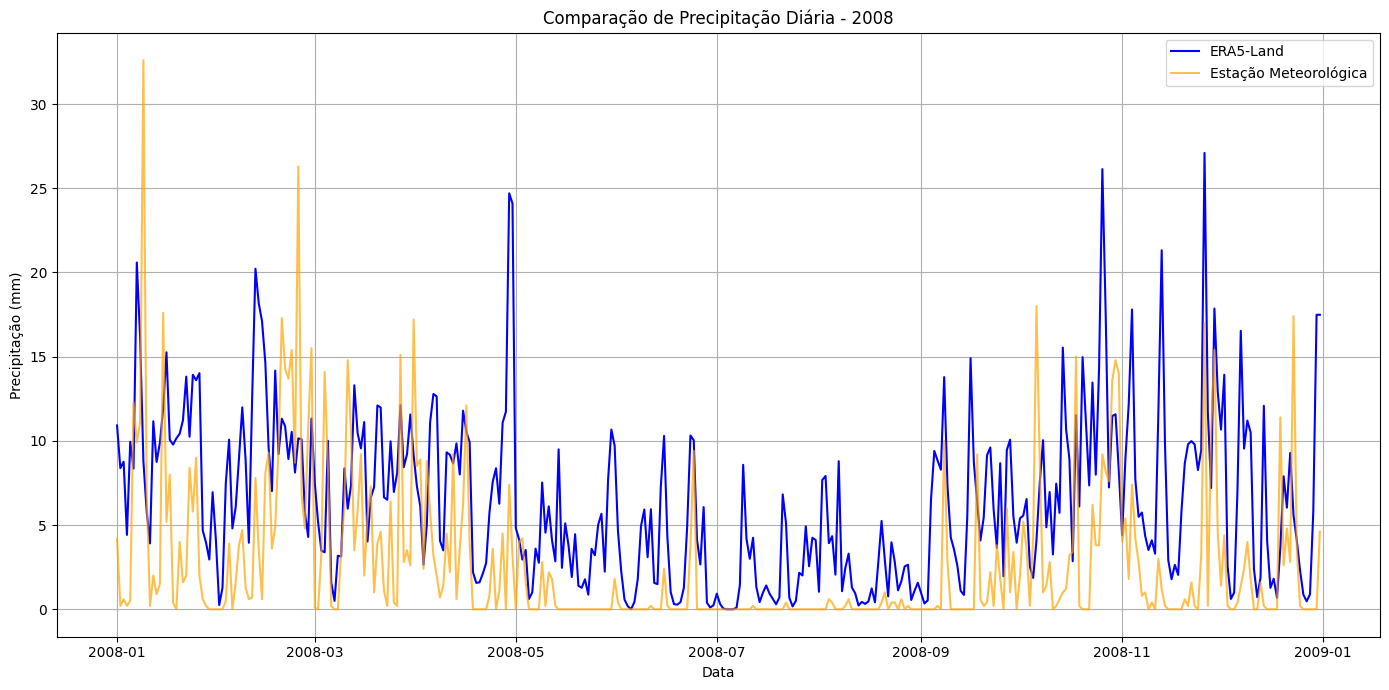

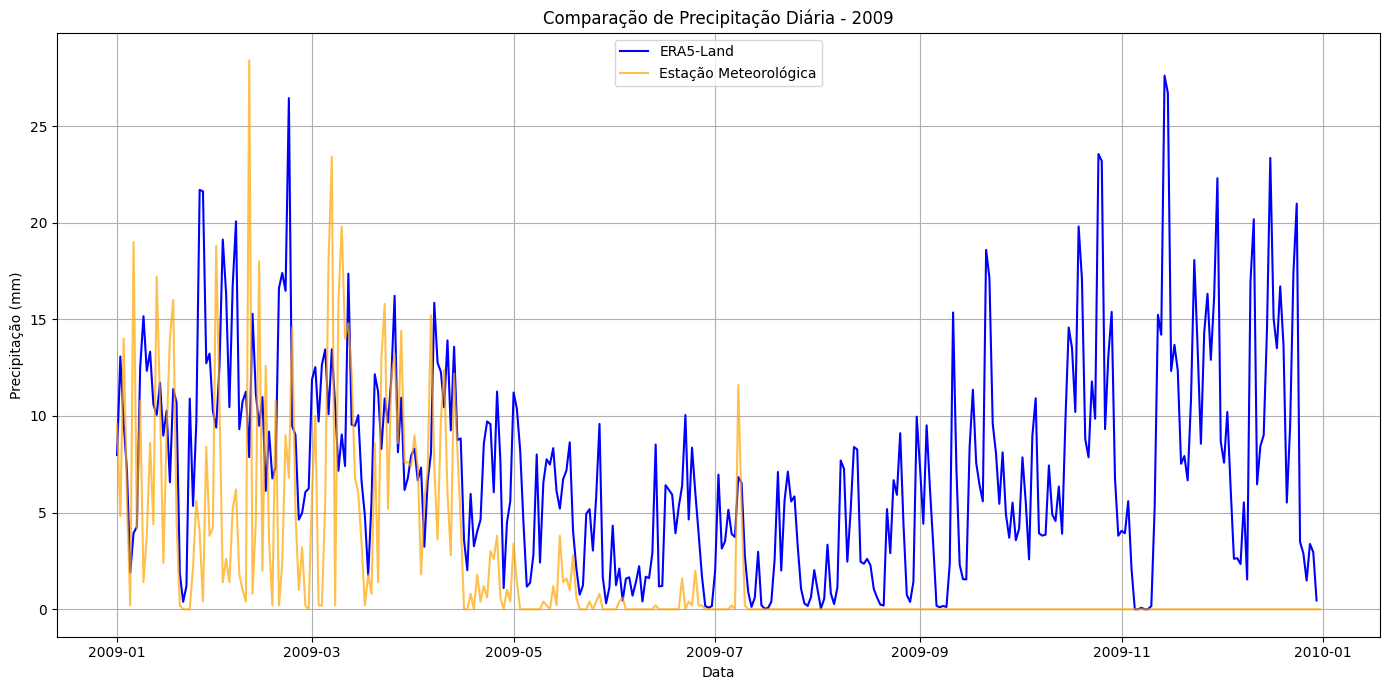

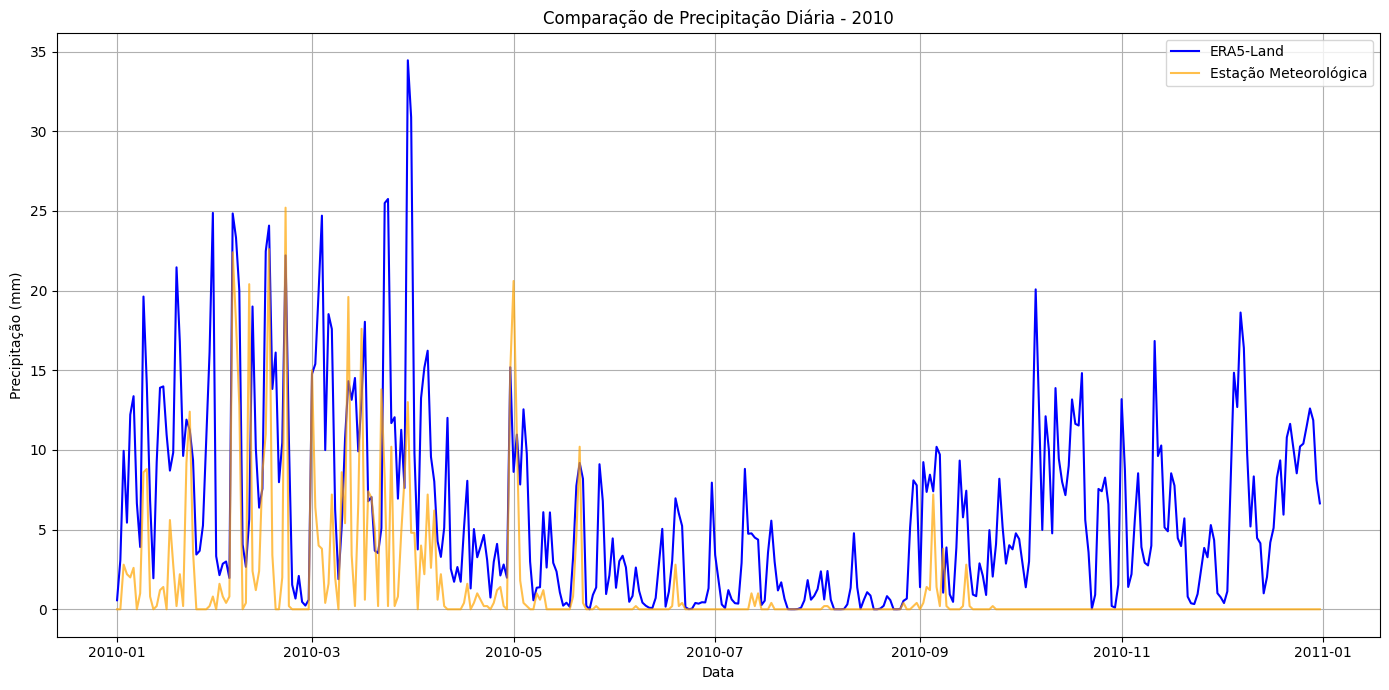

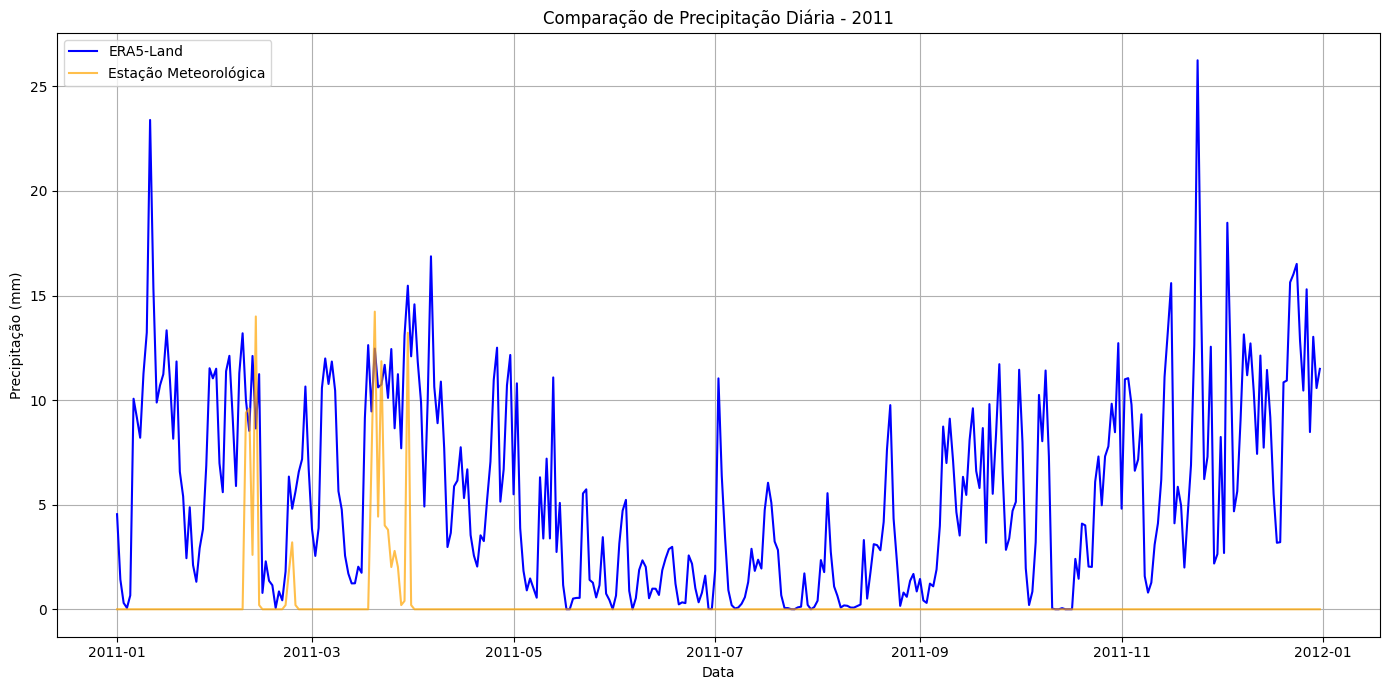

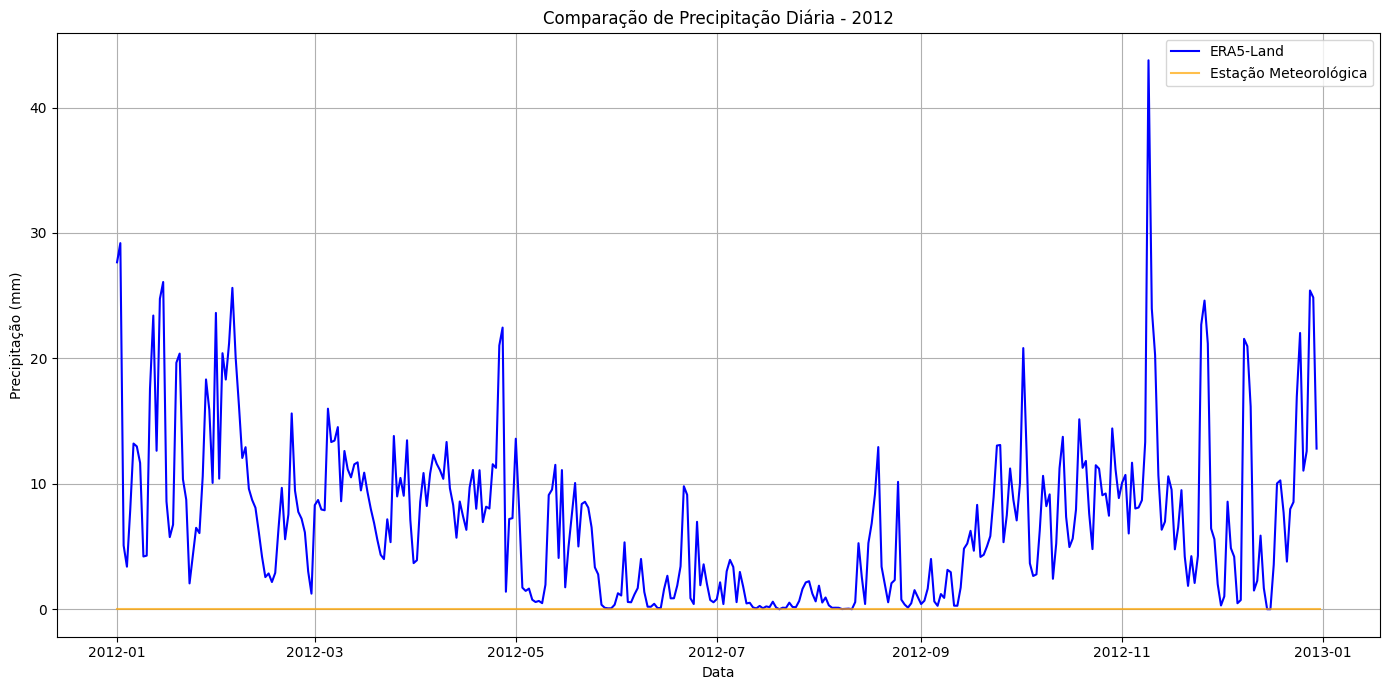

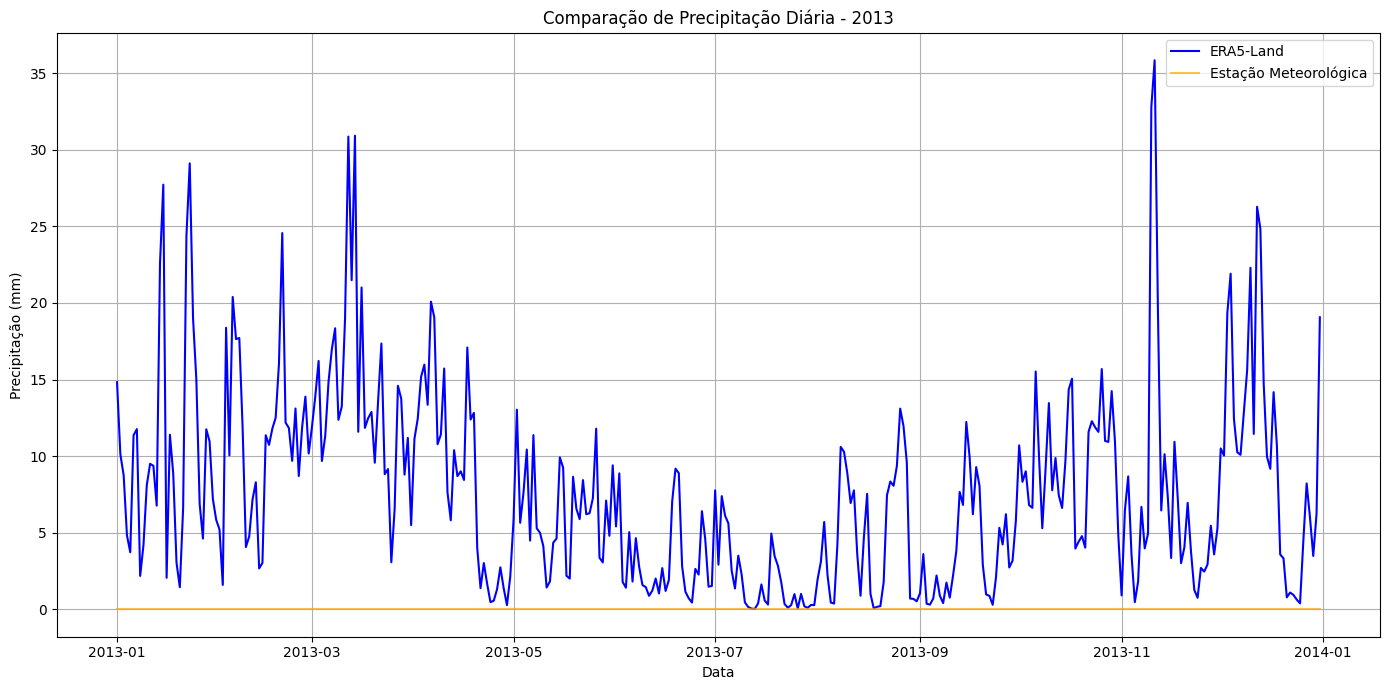

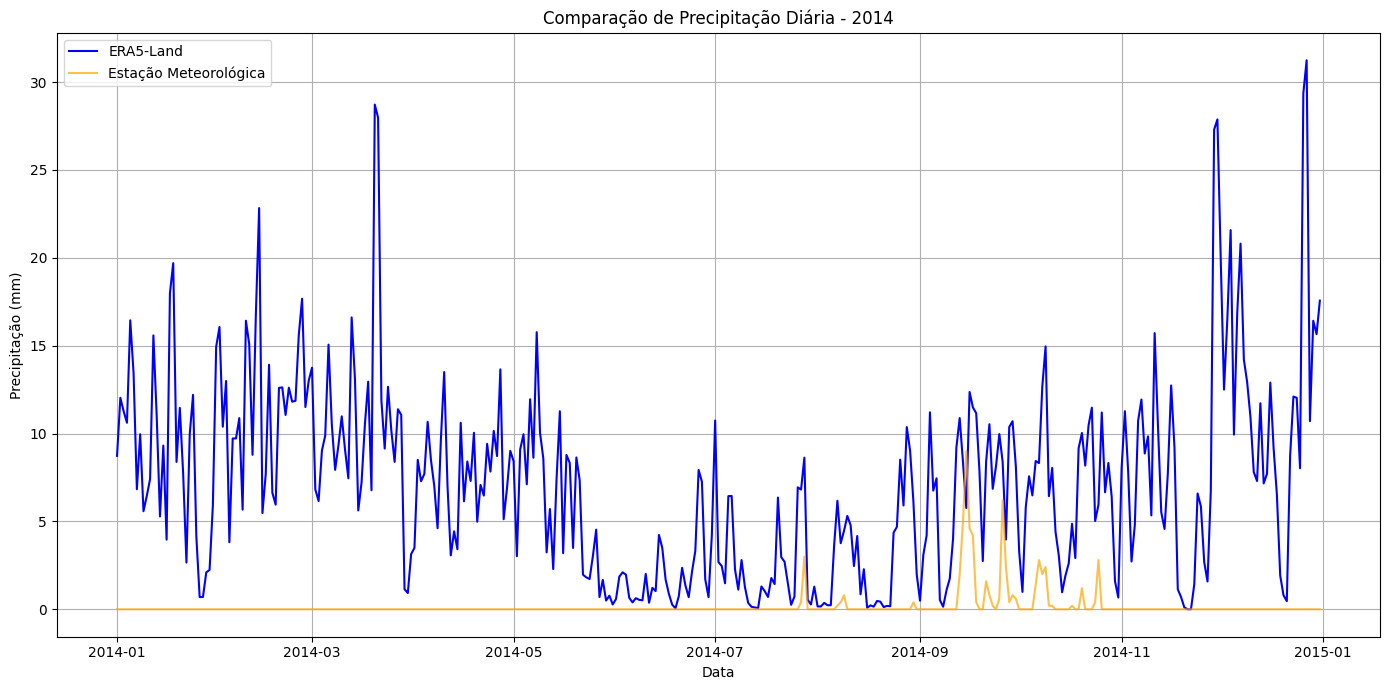

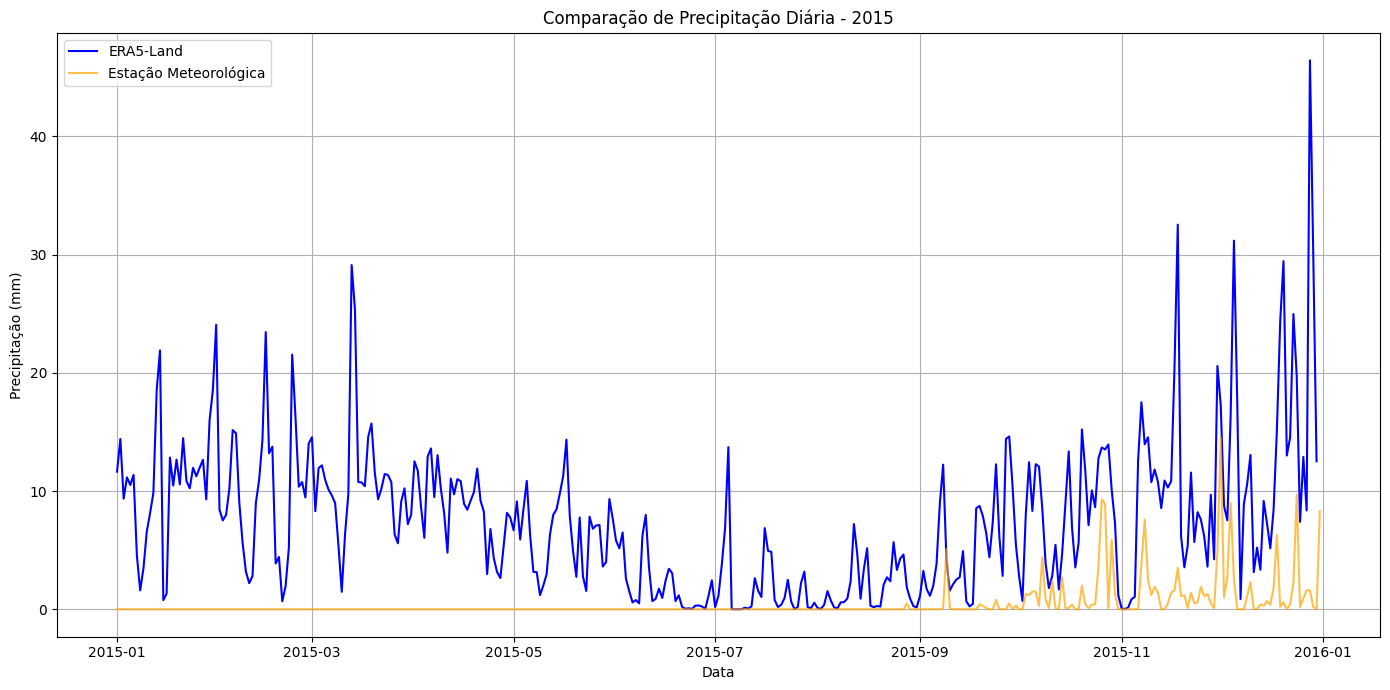

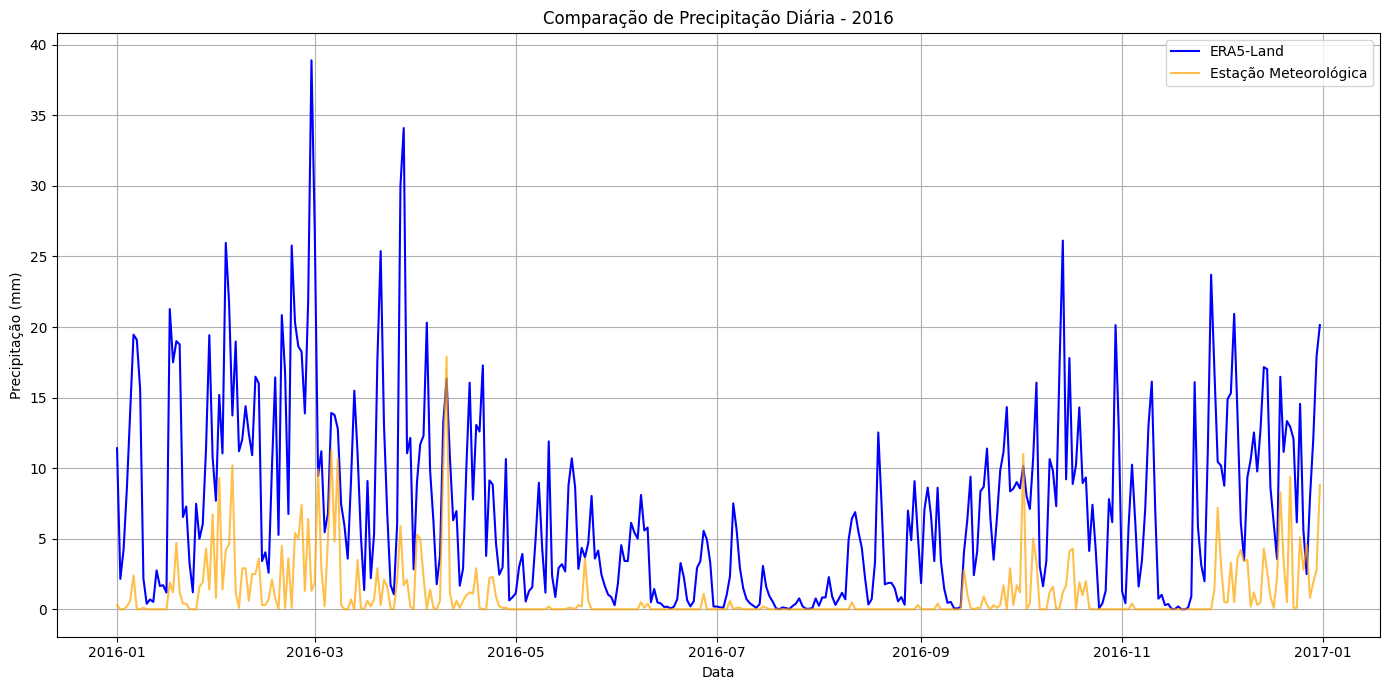

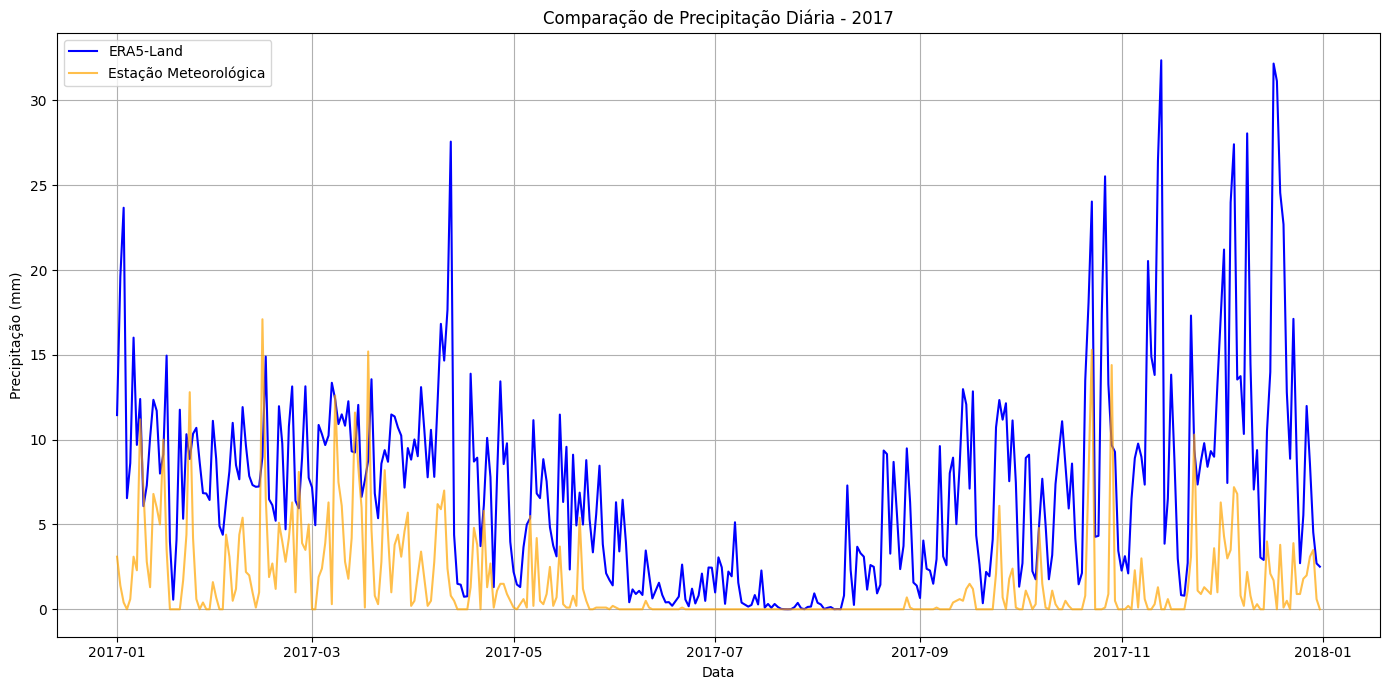

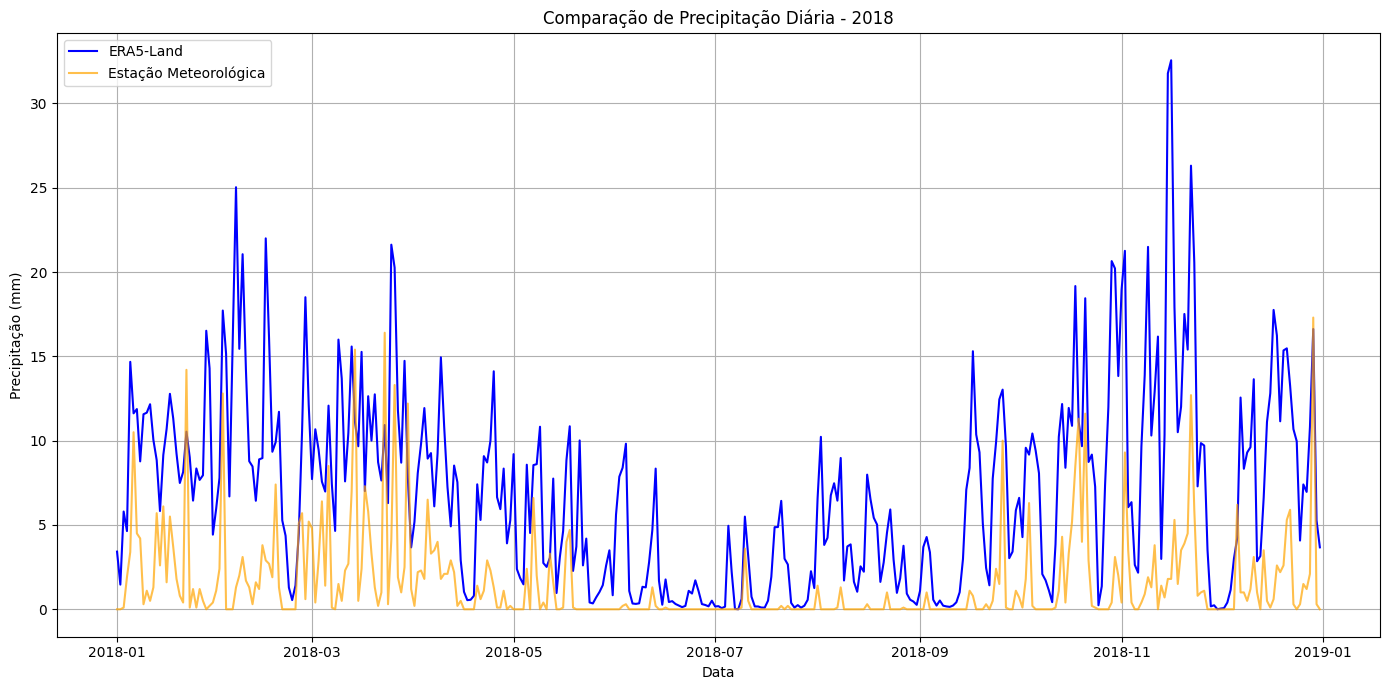

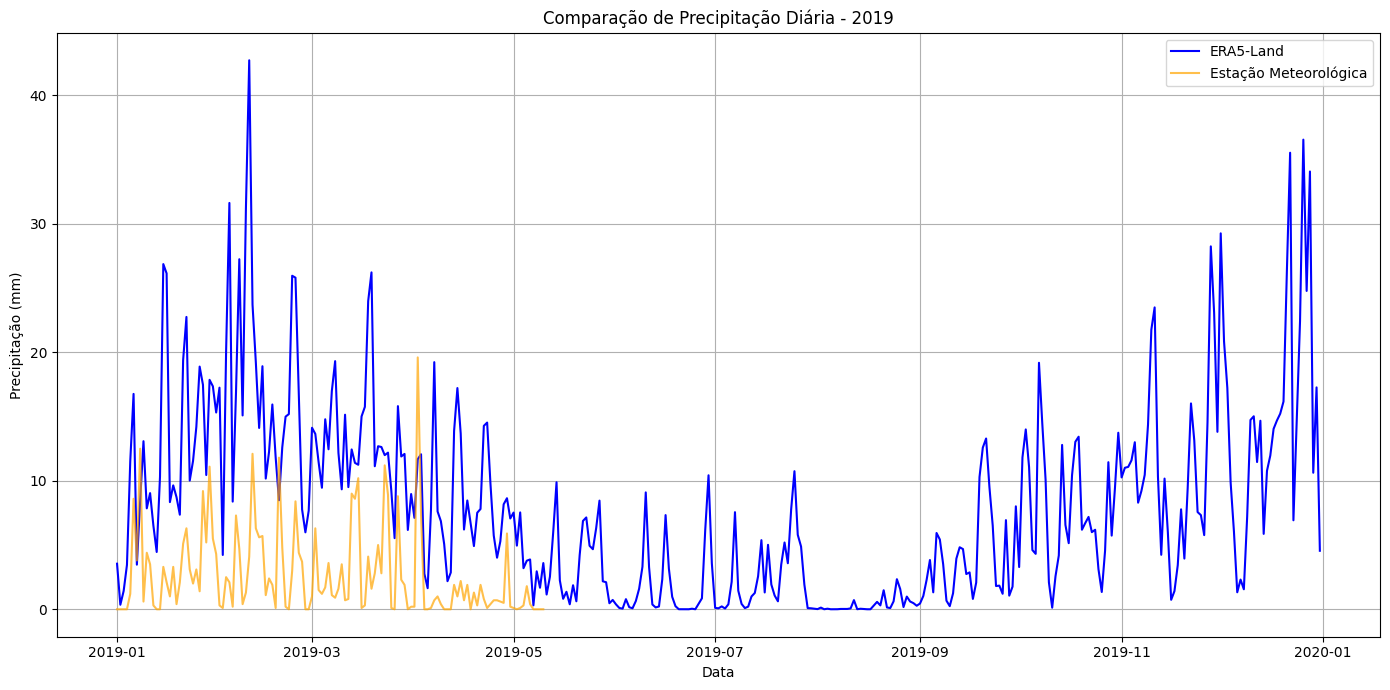

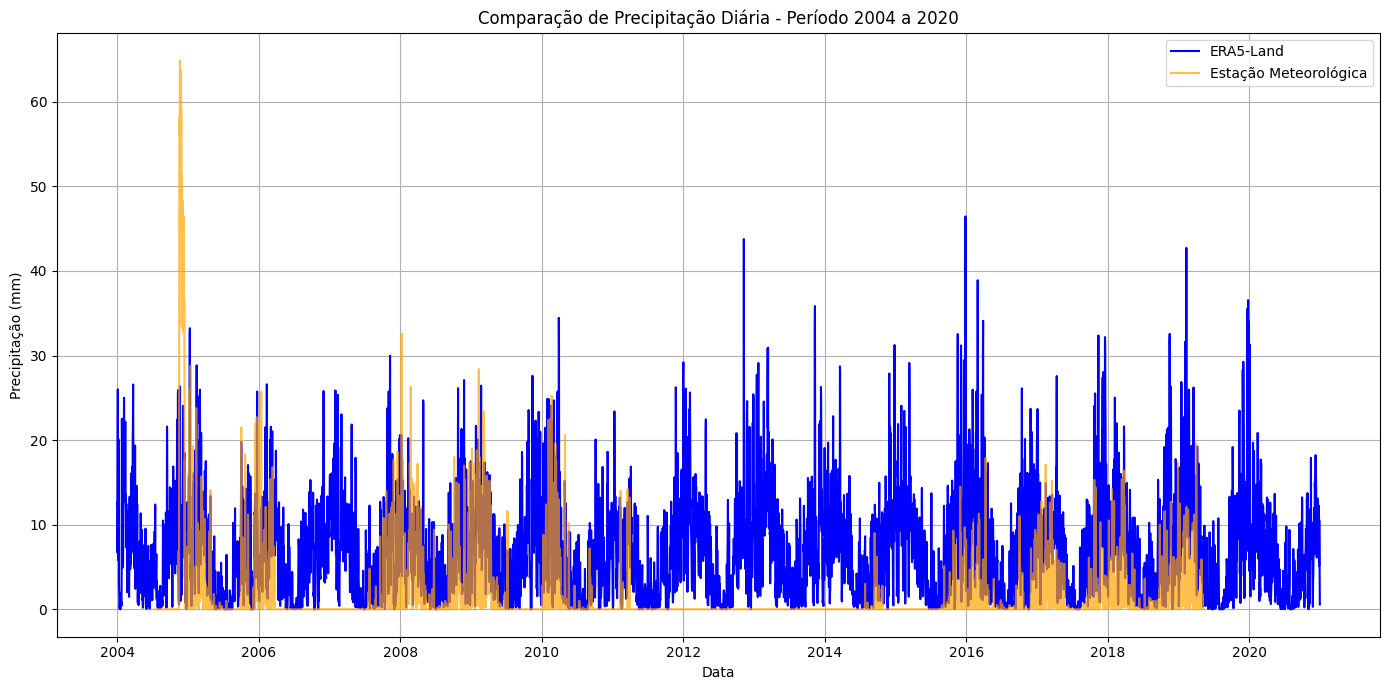

In [15]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Inicializar a API do Google Earth Engine
# -----------------------------
ee.Initialize()

# -----------------------------
# Dados ERA5‑Land (Google Earth Engine)
# -----------------------------
# Definir os dados da estação (coordenadas, nome e cor)
station = {"name": "Llanganuco (LlanQ)", "lat": -9.07, "lon": -77.65, "color": "green"}

# Carregar a coleção de imagens diária do ERA5‑Land e selecionar a variável de precipitação
era5_land_daily = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").select("total_precipitation_sum")

# Função para extrair a precipitação diária de um ponto em um intervalo de datas
def get_daily_precipitation(image_collection, point, start_date, end_date):
    period_collection = image_collection.filterDate(start_date, end_date)
    
    def extract_data(image):
        date = ee.Date(image.get("system:time_start"))
        value = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=9000,
            maxPixels=1e9
        ).get("total_precipitation_sum")
        return ee.Feature(None, {
            "date": date.format("YYYY-MM-dd"),
            "value": ee.Number(value).multiply(1000)  # Converter de m para mm
        })
    
    features = period_collection.map(extract_data).getInfo()["features"]
    data = [
        {
            "date": pd.to_datetime(feature["properties"]["date"]),
            "value": feature["properties"]["value"]
        }
        for feature in features if feature["properties"]["value"] is not None
    ]
    return pd.DataFrame(data)

# Dividir o período em intervalos para evitar limites de requisição (2004 a 2020)
date_ranges = [
    ("2004-01-01", "2006-12-31"),
    ("2007-01-01", "2009-12-31"),
    ("2010-01-01", "2012-12-31"),
    ("2013-01-01", "2015-12-31"),
    ("2016-01-01", "2020-12-31")
]

# Obter os dados do ERA5‑Land para o ponto da estação
point = ee.Geometry.Point([station["lon"], station["lat"]])
dfs = []
for start_date, end_date in date_ranges:
    df = get_daily_precipitation(era5_land_daily, point, start_date, end_date)
    dfs.append(df)
era5_df = pd.concat(dfs)
era5_df.sort_values(by='date', inplace=True)

# -----------------------------
# Dados da Estação Meteorológica
# -----------------------------
# Caminho para o arquivo CSV (ajuste conforme necessário)
csv_path = "../../Weather Station Data/Llanganuco_LLANWX_12Jul04_10May19.csv"
dados = pd.read_csv(csv_path, encoding="latin1")

# Converter a coluna de data para datetime
dados['Data'] = pd.to_datetime(dados['Datetime'], format='%m/%d/%Y %H:%M')

# Filtrar o período de interesse: 2004-01-01 a 2020-12-31
mask = (dados['Data'] >= '2004-01-01') & (dados['Data'] <= '2020-12-31')
dados = dados[mask]

# Calcular a soma diária da precipitação
dados.set_index('Data', inplace=True)
soma_diaria = dados['Precipitation (mm)'].resample('D').sum().reset_index()
station_df = soma_diaria.rename(columns={'Data': 'date', 'Precipitation (mm)': 'value'})
station_df.sort_values(by='date', inplace=True)

# -----------------------------
# Gráficos Comparativos por Ano (2004 a 2020)
# -----------------------------
anos = range(2004, 2021)  # De 2004 até 2020

for ano in anos:
    # Filtrar os dados para o ano atual
    era5_ano = era5_df[era5_df['date'].dt.year == ano]
    station_ano = station_df[station_df['date'].dt.year == ano]
    
    # Caso algum dos conjuntos não possua dados para o ano, pula o gráfico
    if era5_ano.empty or station_ano.empty:
        continue

    plt.figure(figsize=(14, 7))
    plt.plot(era5_ano["date"], era5_ano["value"], label="ERA5‑Land", color="blue")
    plt.plot(station_ano["date"], station_ano["value"], label="Estação Meteorológica", color="orange", alpha=0.7)
    plt.title(f"Comparação de Precipitação Diária - {ano}")
    plt.xlabel("Data")
    plt.ylabel("Precipitação (mm)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Gráfico Comparativo para Todo o Período (2004 a 2020)
# -----------------------------
plt.figure(figsize=(14, 7))
plt.plot(era5_df["date"], era5_df["value"], label="ERA5‑Land", color="blue")
plt.plot(station_df["date"], station_df["value"], label="Estação Meteorológica", color="orange", alpha=0.7)
plt.title("Comparação de Precipitação Diária - Período 2004 a 2020")
plt.xlabel("Data")
plt.ylabel("Precipitação (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/tmp/ipykernel_6730/1293926621.py:67: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_station = pd.read_csv(csv_path, encoding="latin1")


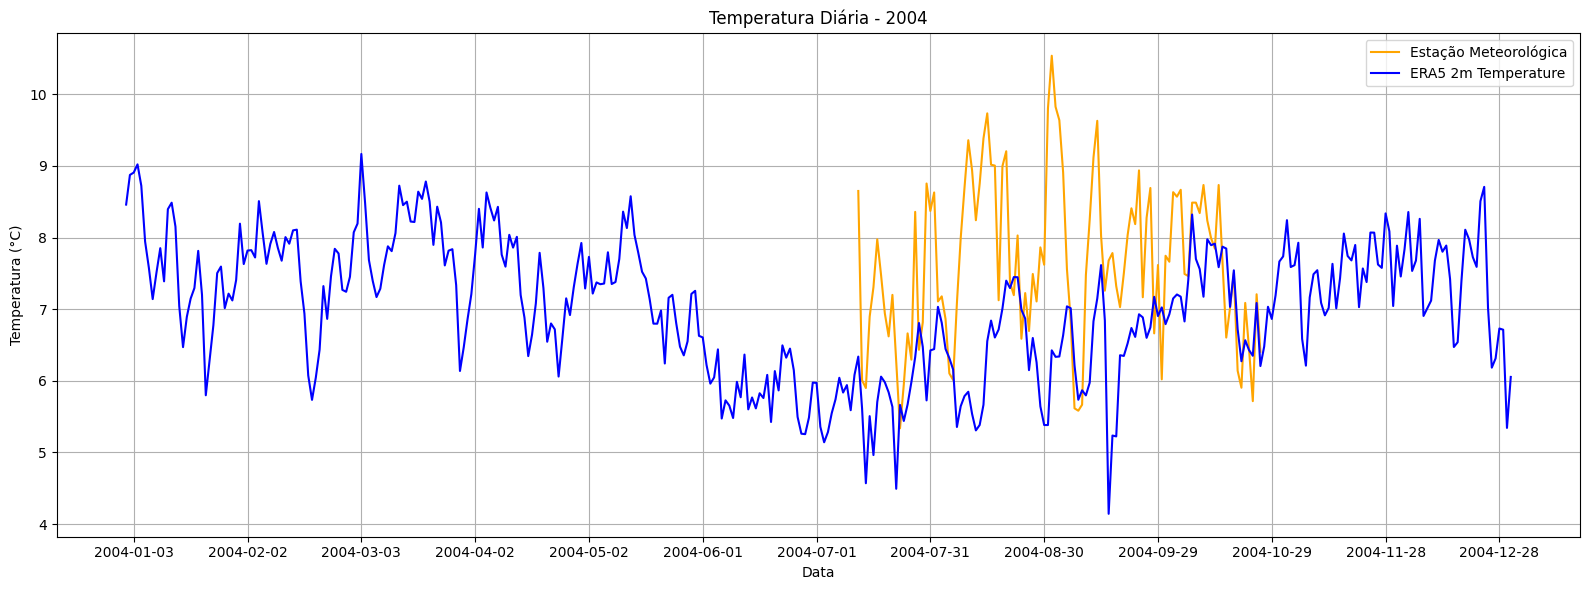

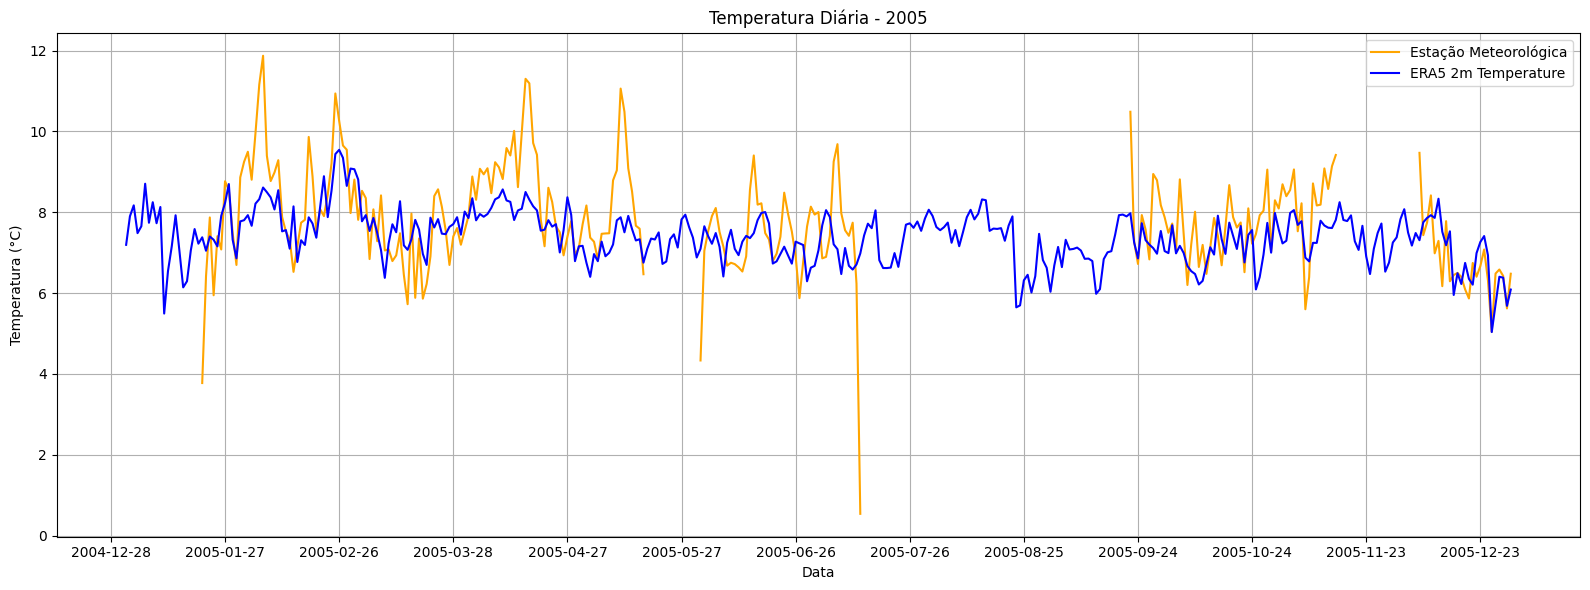

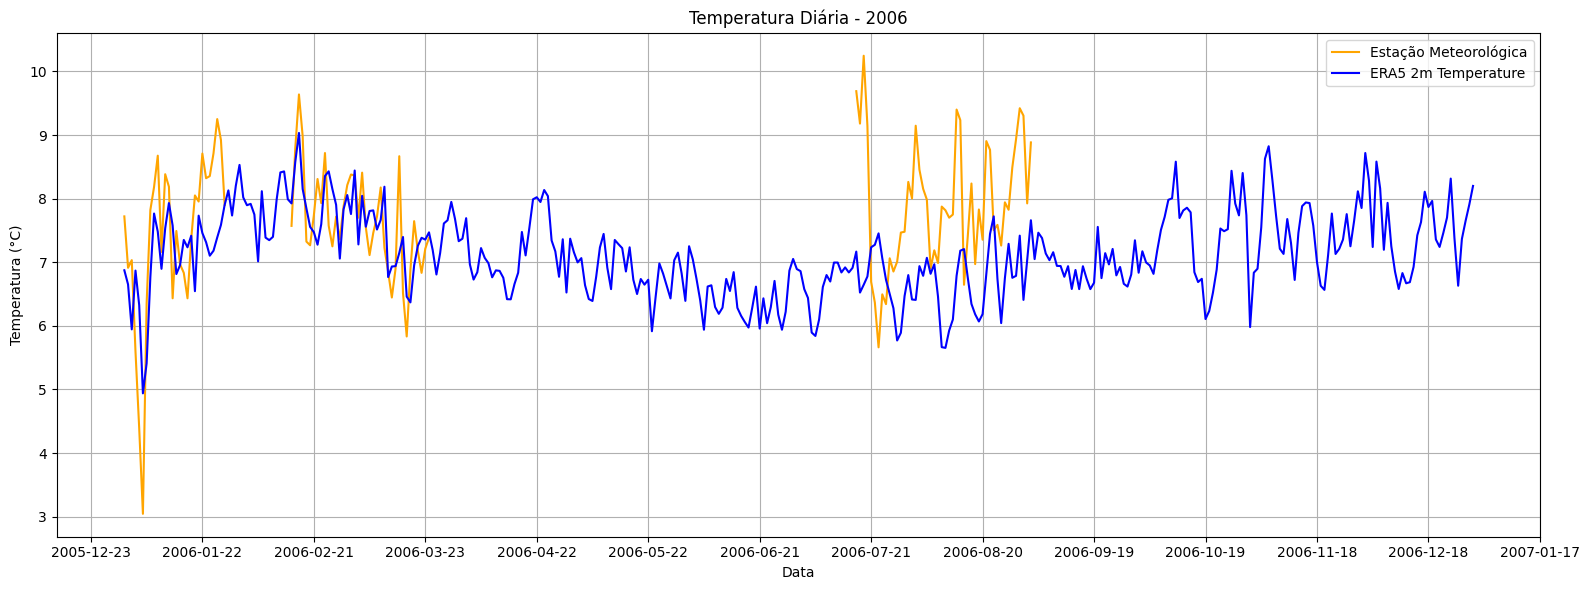

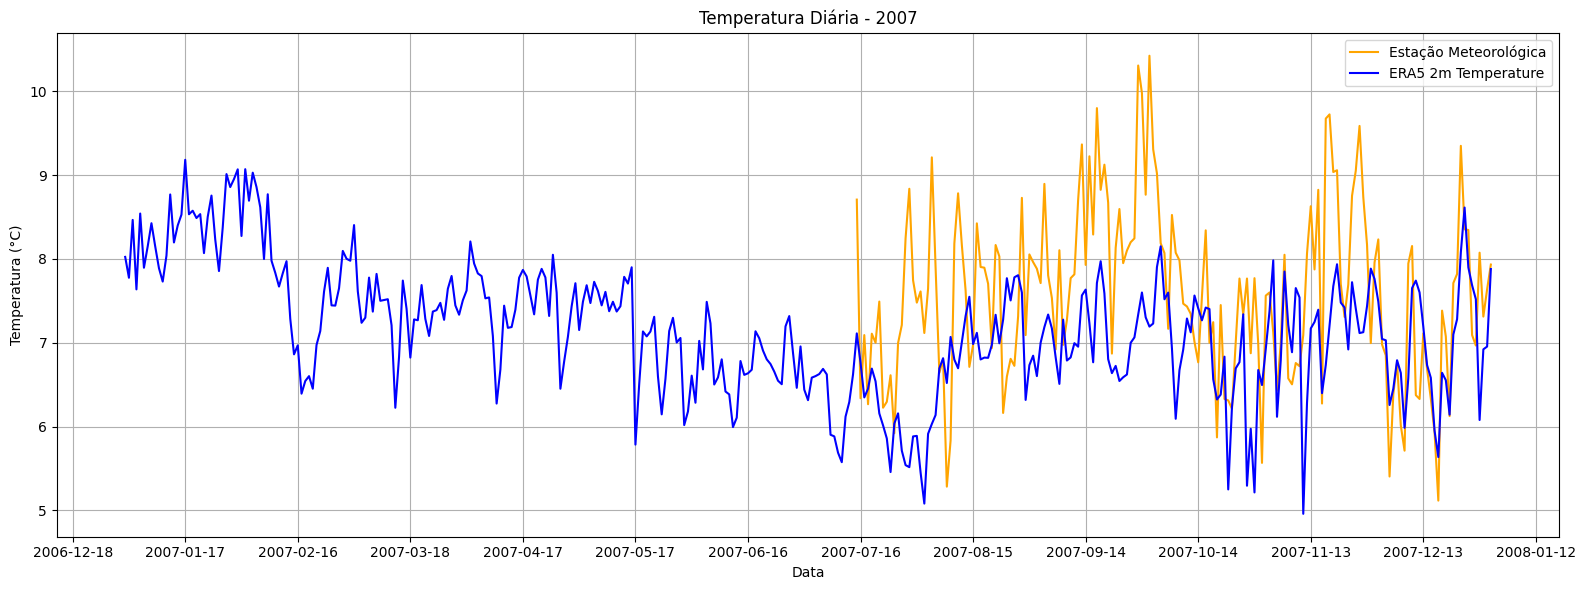

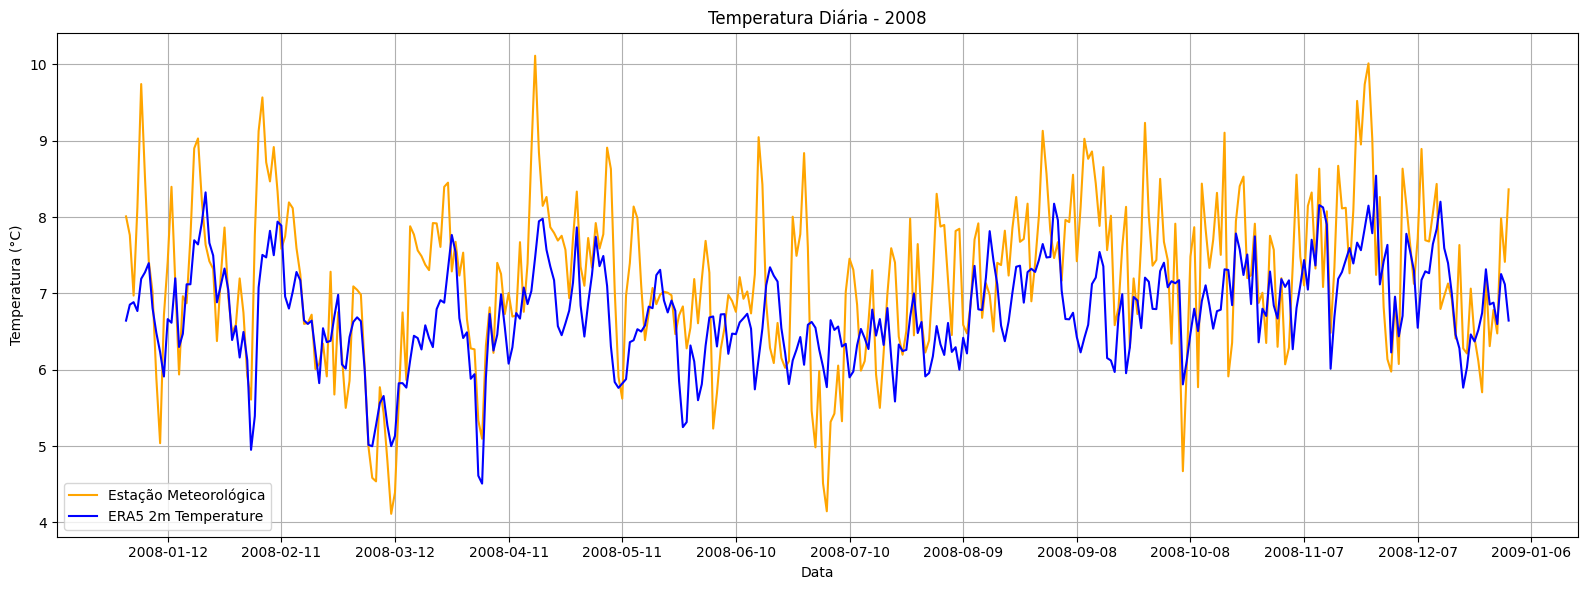

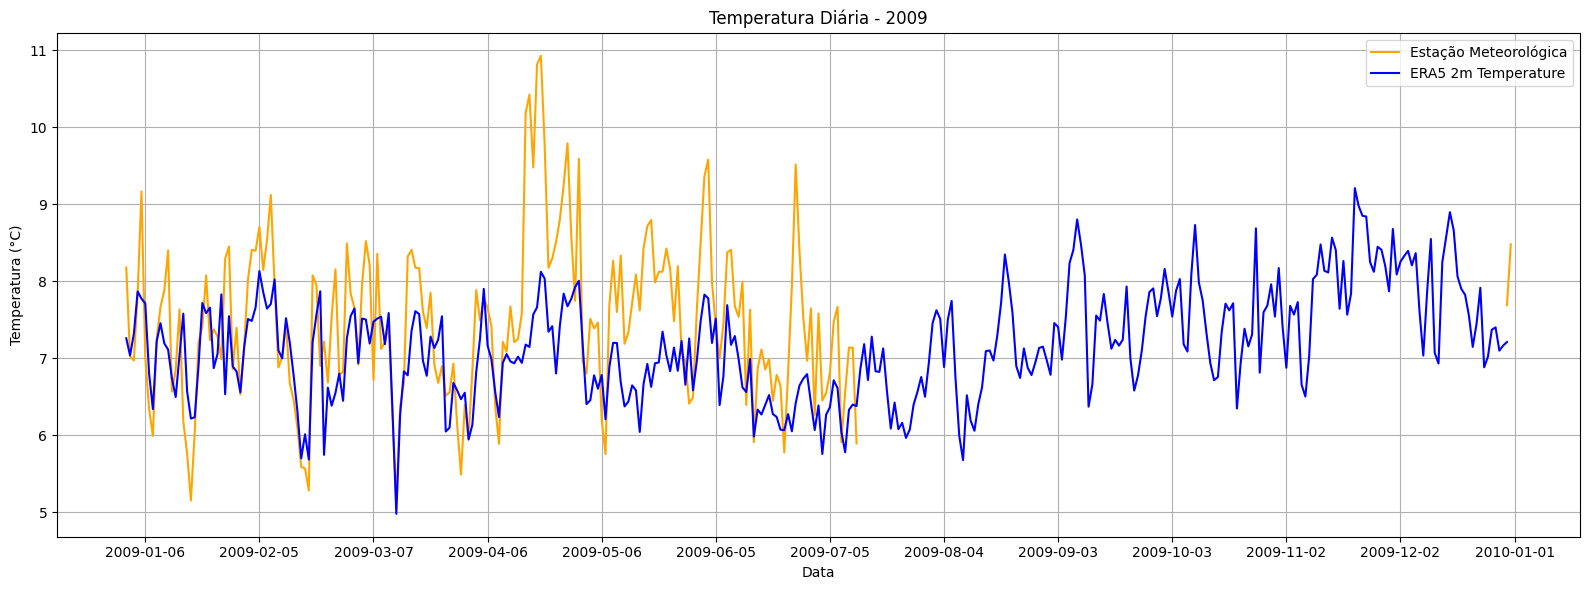

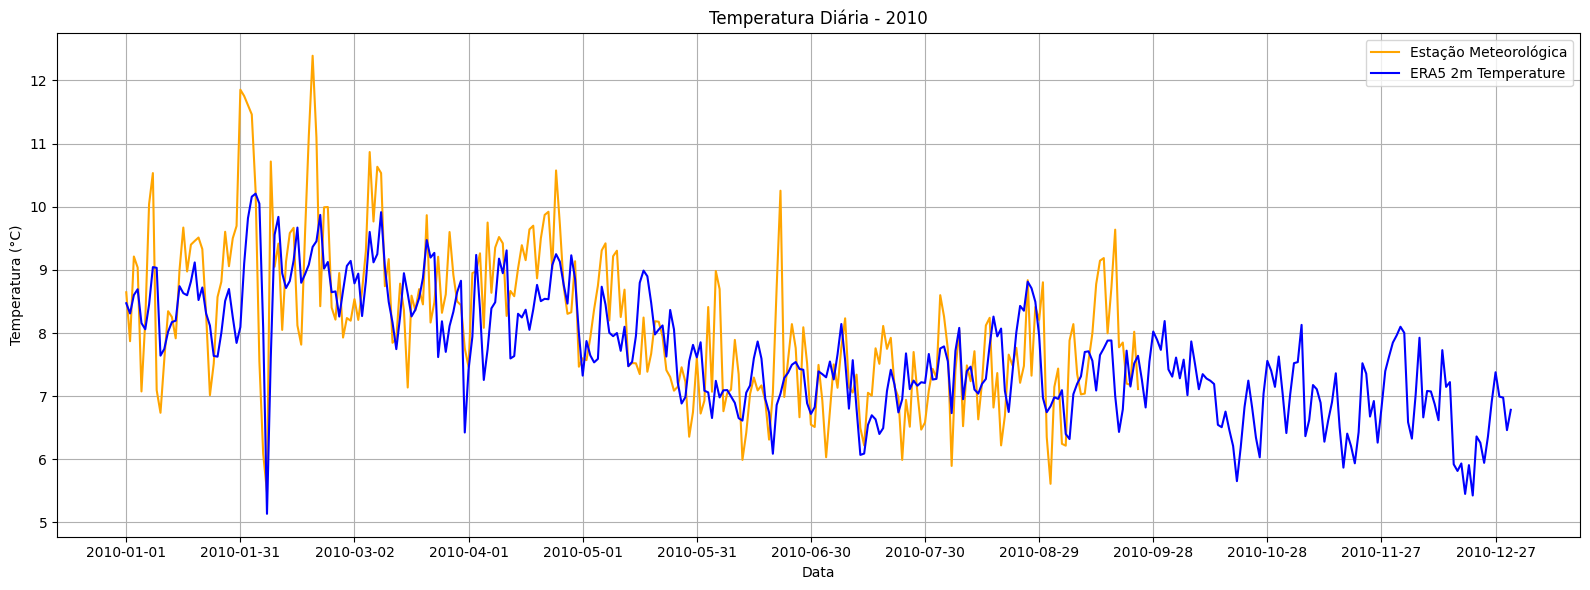

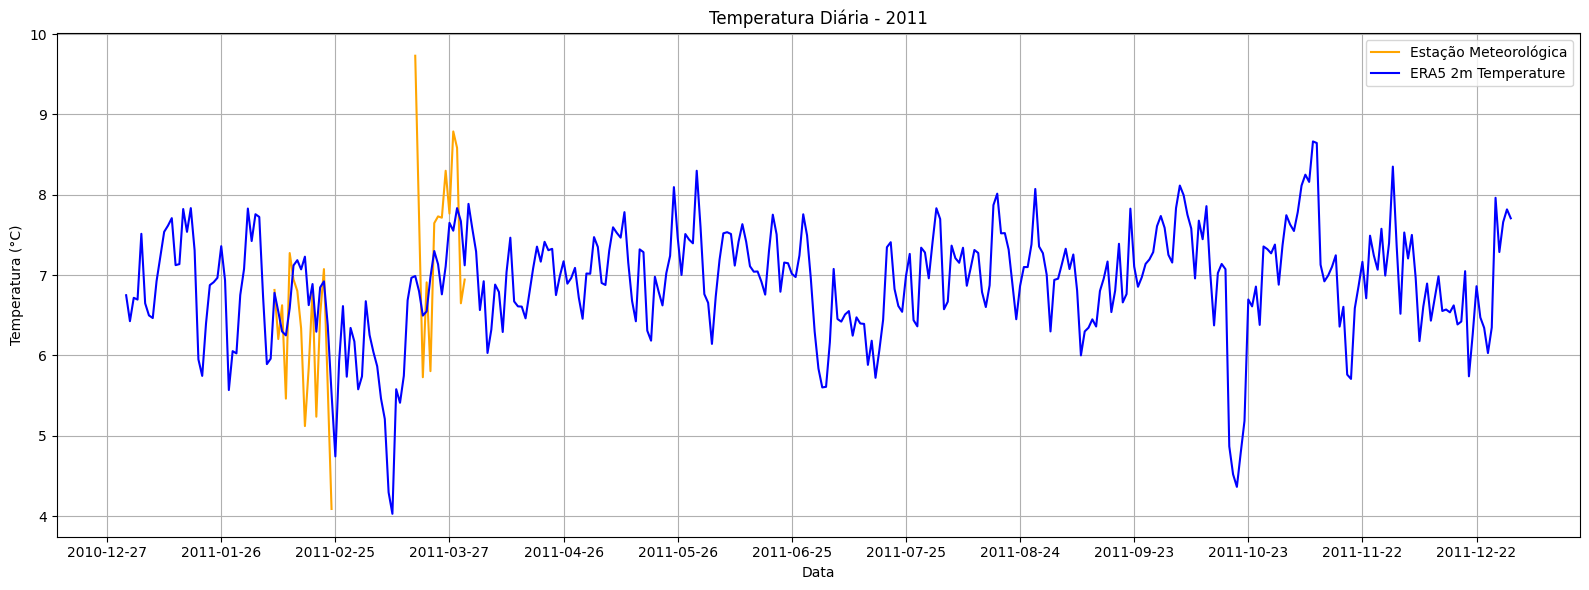

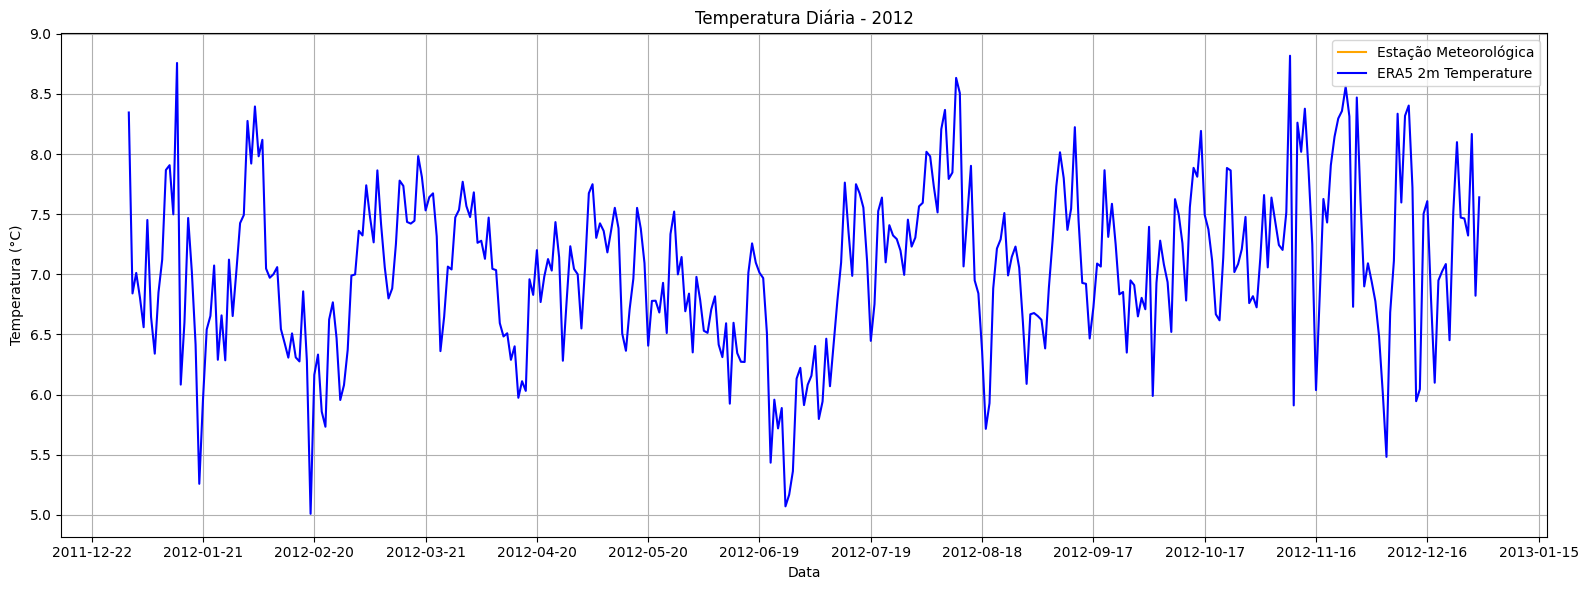

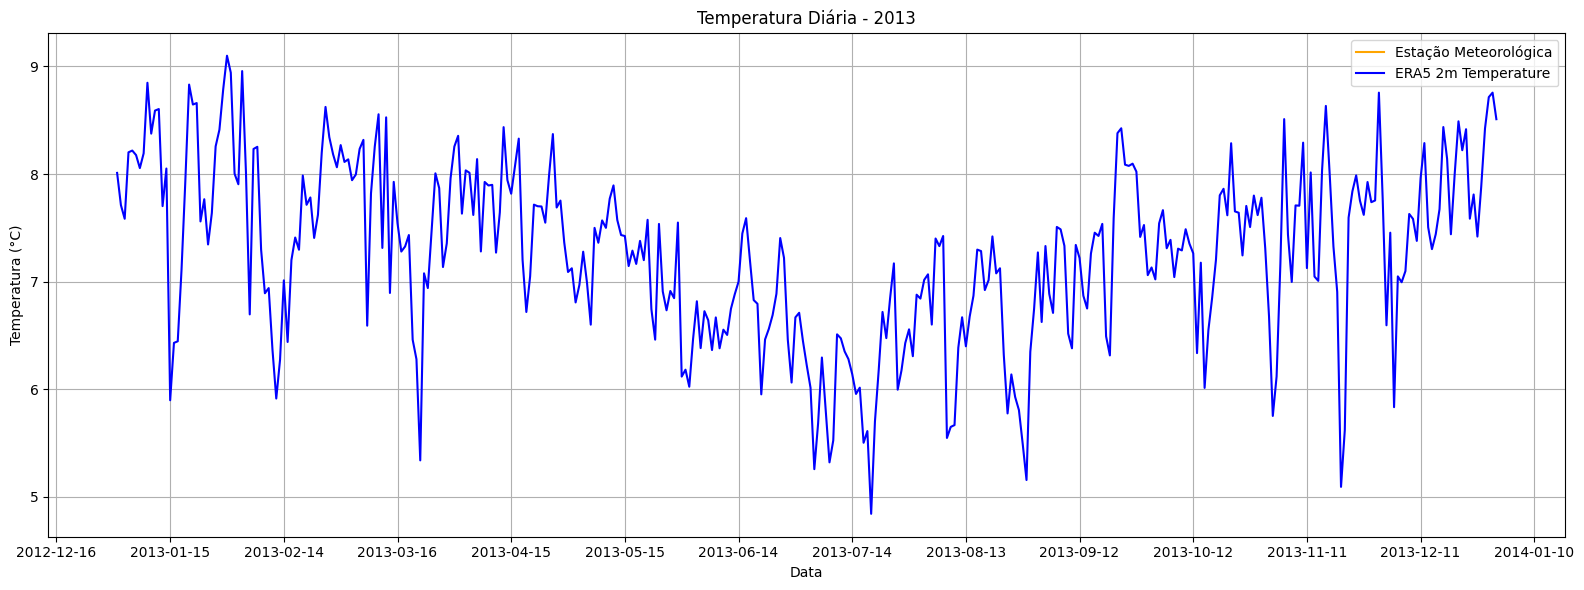

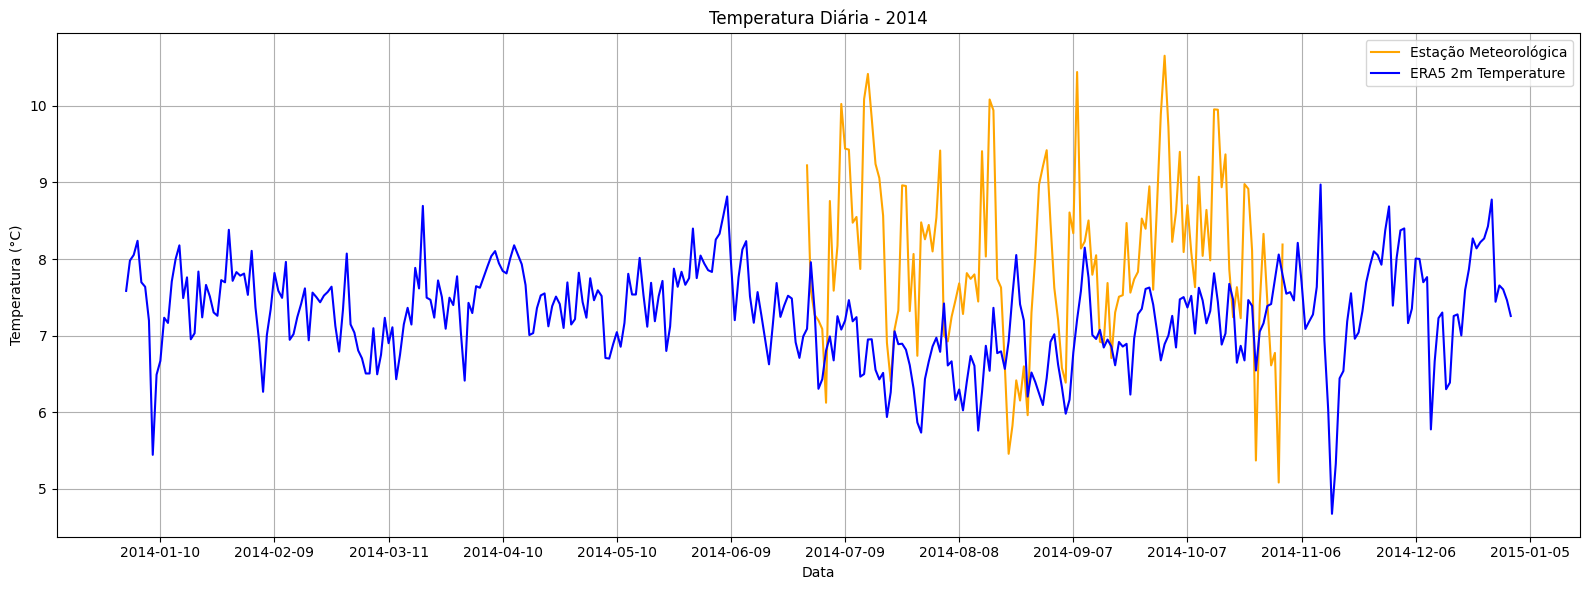

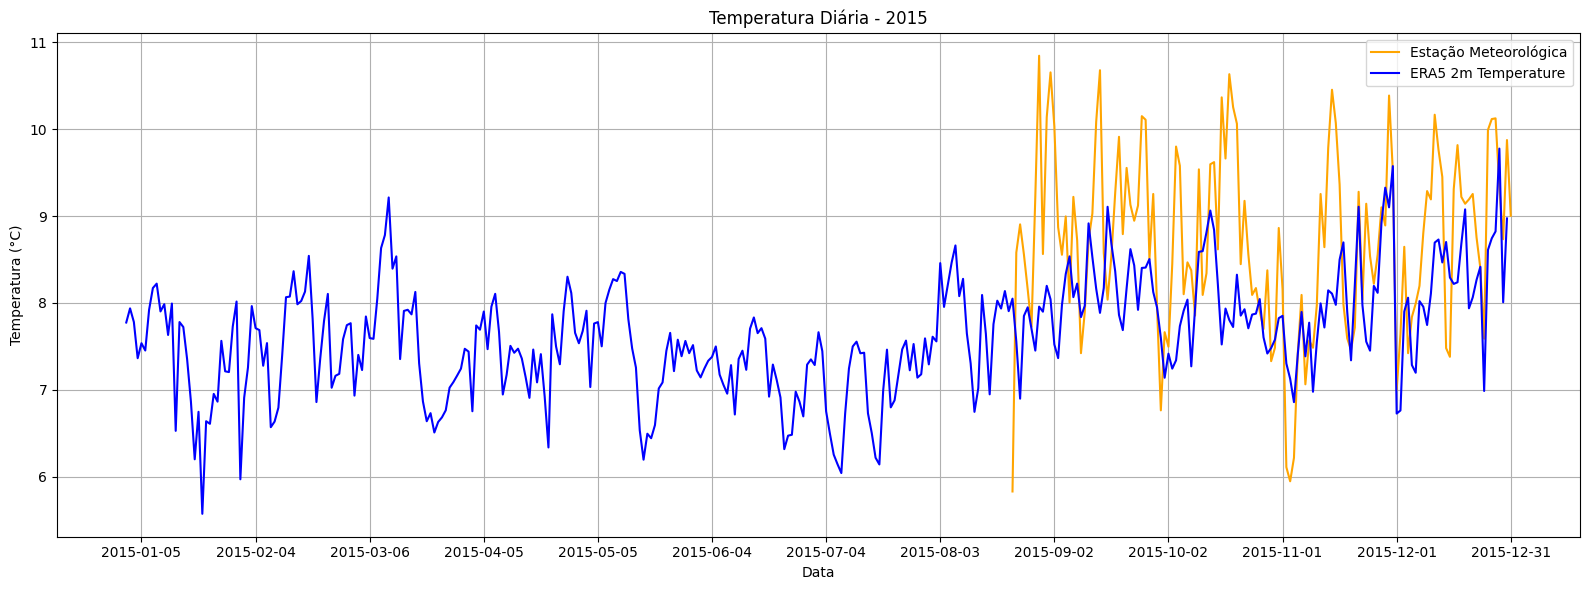

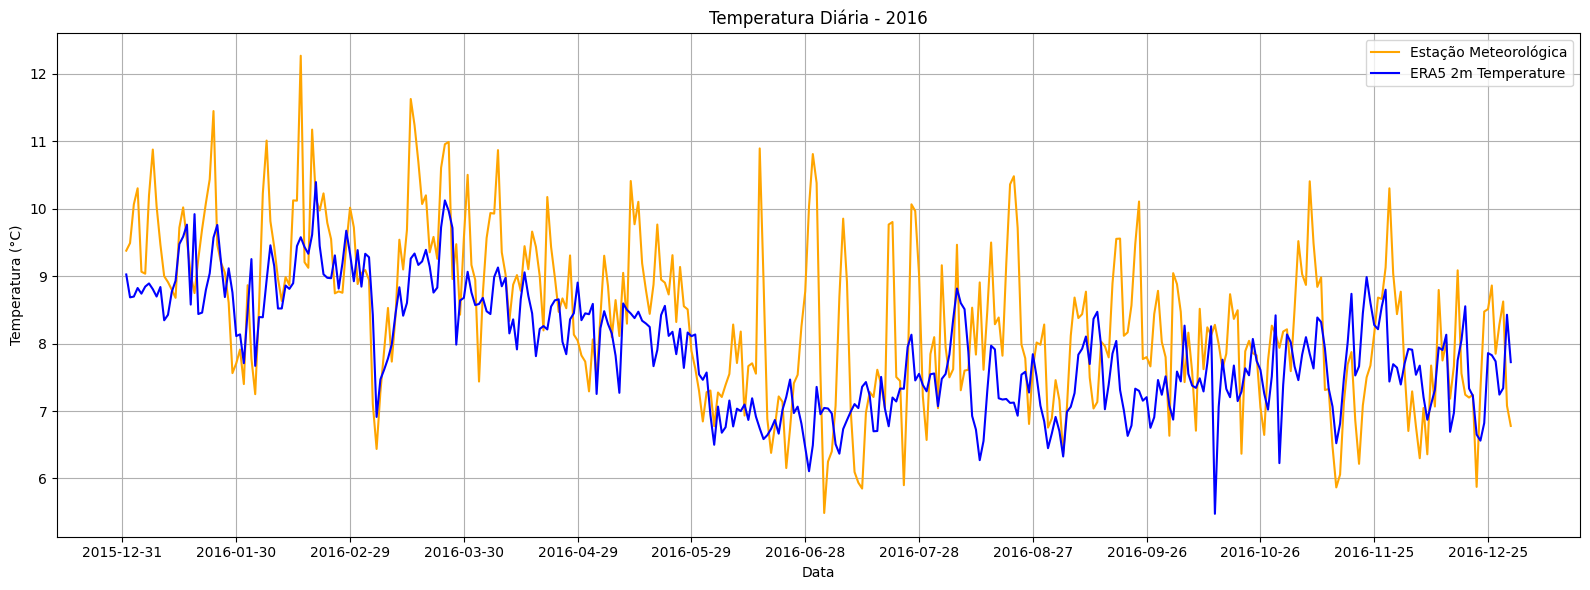

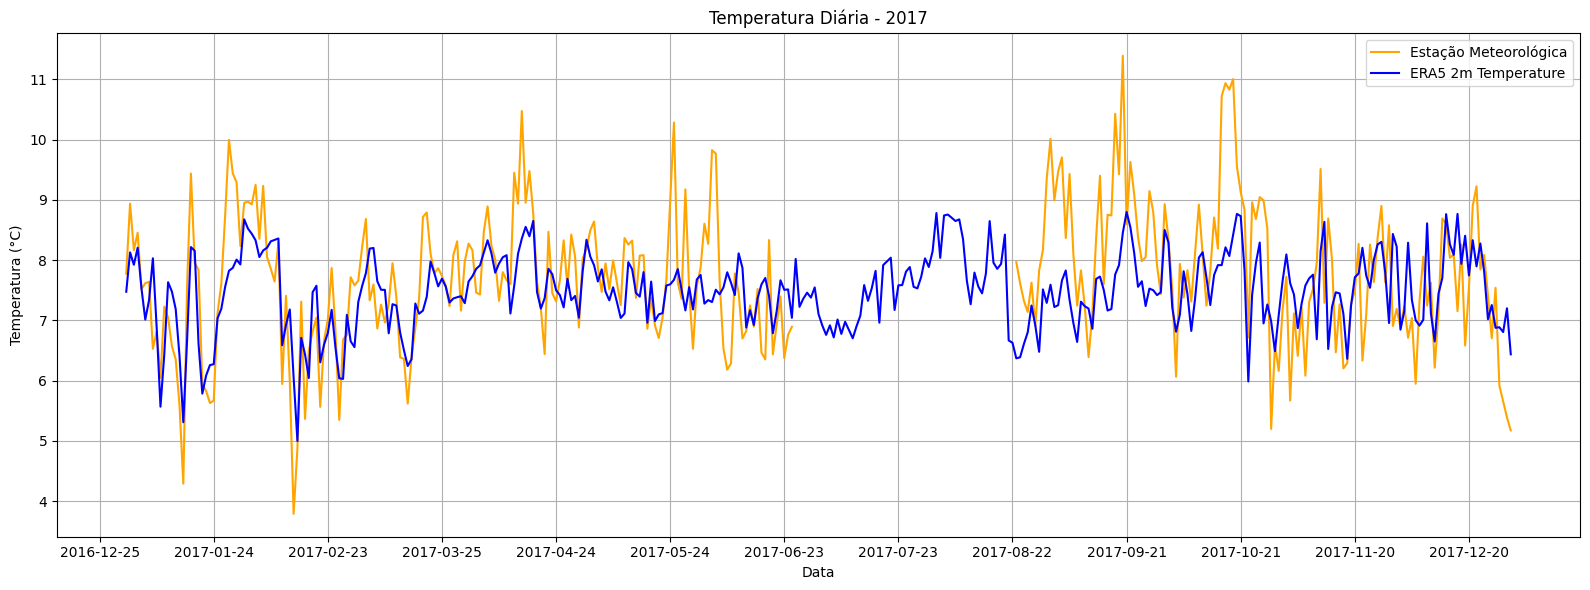

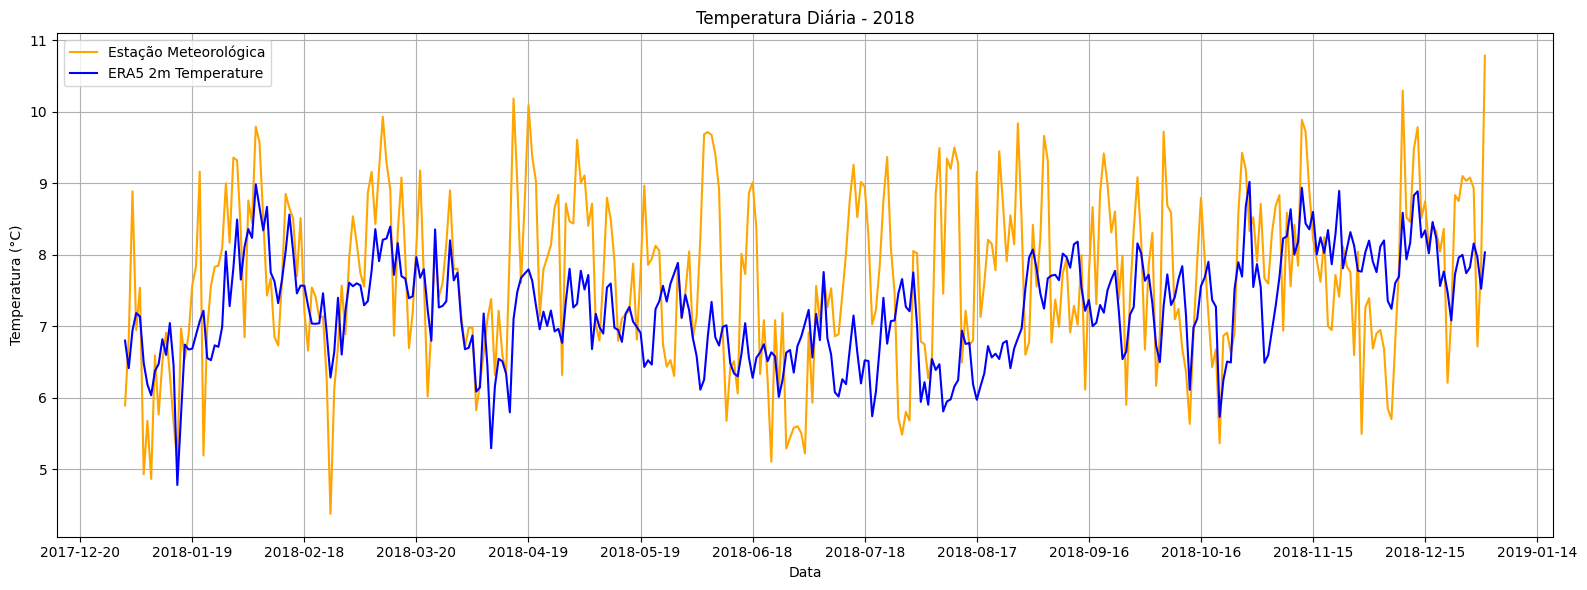

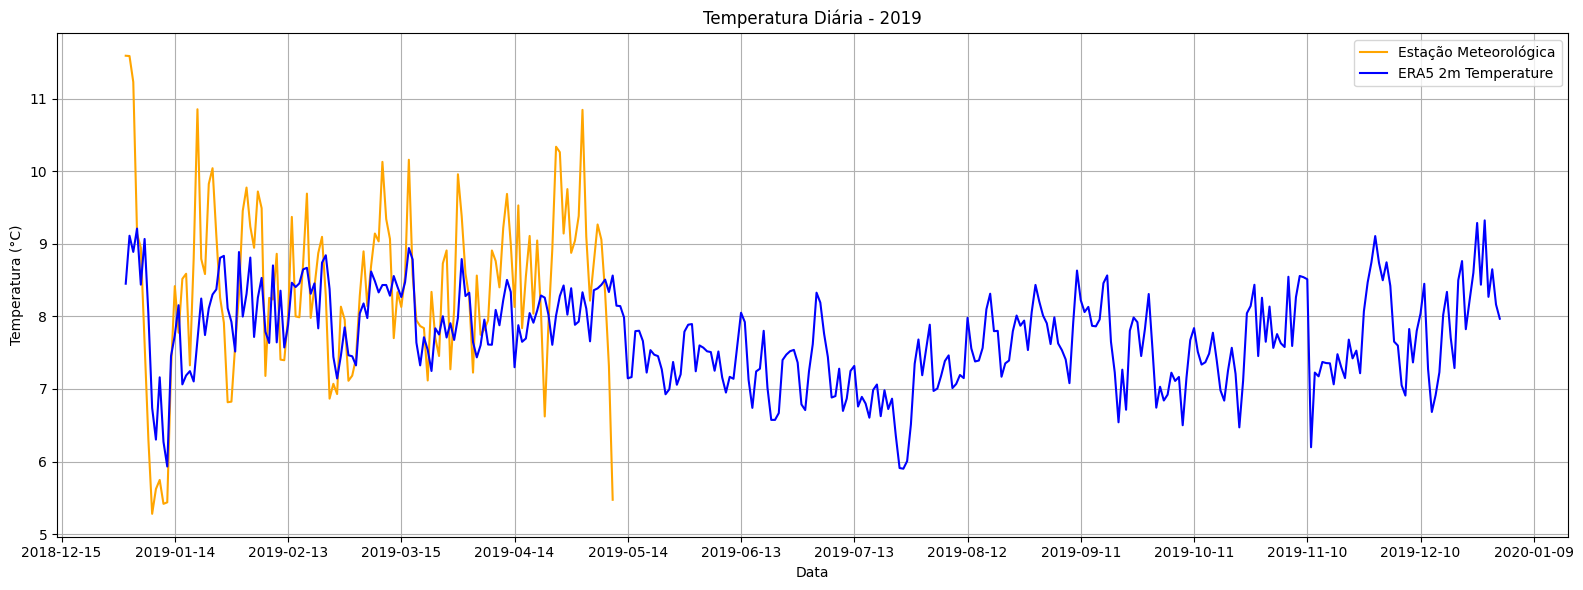

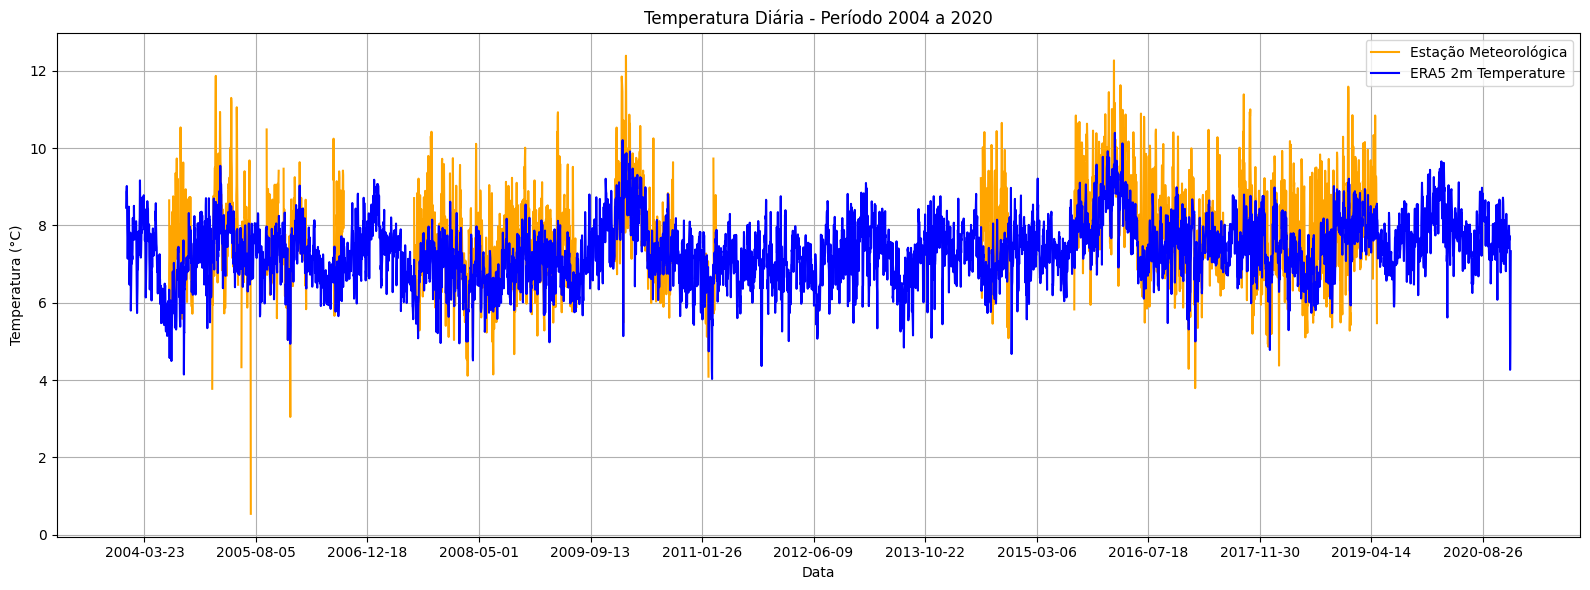

In [20]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Inicializar a API do Google Earth Engine
# -----------------------------
ee.Initialize()

# -----------------------------
# Dados ERA5‑Land - Temperatura a 2m (Google Earth Engine)
# -----------------------------
# Definir os dados da estação (coordenadas, nome, etc.)
station = {"name": "Llanganuco (LlanQ)", "lat": -9.07, "lon": -77.65, "color": "green"}

# Carregar a coleção de imagens diária do ERA5‑Land e selecionar a variável "temperature_2m"
# OBS.: A temperatura está em Kelvin e será convertida para °C (subtraindo 273.15)
era5_land_daily = ee.ImageCollection("ECMWF/ERA5_LAND/DAILY_AGGR").select("temperature_2m")

def get_daily_temperature(image_collection, point, start_date, end_date):
    period_collection = image_collection.filterDate(start_date, end_date)
    
    def extract_data(image):
        date = ee.Date(image.get("system:time_start"))
        temp = image.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=point,
            scale=9000,
            maxPixels=1e9
        ).get("temperature_2m")
        return ee.Feature(None, {
            "date": date.format("YYYY-MM-dd"),
            "temperature": ee.Number(temp).subtract(273.15)  # Converter de Kelvin para °C
        })
    
    features = period_collection.map(extract_data).getInfo()["features"]
    data = [
        {
            "date": pd.to_datetime(feature["properties"]["date"]),
            "temperature": feature["properties"]["temperature"]
        }
        for feature in features if feature["properties"]["temperature"] is not None
    ]
    return pd.DataFrame(data)

# Dividir o período (2004 a 2020) em intervalos para evitar limites de requisição
date_ranges = [
    ("2004-01-01", "2006-12-31"),
    ("2007-01-01", "2009-12-31"),
    ("2010-01-01", "2012-12-31"),
    ("2013-01-01", "2015-12-31"),
    ("2016-01-01", "2020-12-31")
]

point = ee.Geometry.Point([station["lon"], station["lat"]])
dfs = []
for start_date, end_date in date_ranges:
    df_temp = get_daily_temperature(era5_land_daily, point, start_date, end_date)
    dfs.append(df_temp)
era5_temp_df = pd.concat(dfs)
era5_temp_df.sort_values(by='date', inplace=True)

# -----------------------------
# Dados da Estação Meteorológica - Temperatura
# -----------------------------
csv_path = "../../Weather Station Data/Llanganuco_LLANWX_12Jul04_10May19.csv"
df_station = pd.read_csv(csv_path, encoding="latin1")

# Converter a coluna de data para datetime e definir como índice
df_station['Datetime'] = pd.to_datetime(df_station['Datetime'], format='%m/%d/%Y %H:%M')
df_station.set_index('Datetime', inplace=True)

# Calcular a média diária da temperatura (°C)
df_station_daily = df_station['Temperature (°C)'].resample('D').mean().reset_index()
# Renomear a coluna 'Datetime' para 'date' para padronização
df_station_daily.rename(columns={'Datetime': 'date', 'Temperature (°C)': 'temperature'}, inplace=True)
df_station_daily.sort_values(by='date', inplace=True)

# -----------------------------
# Gráficos Anuais - Comparando Temperatura (Estação vs. ERA5 2m)
# -----------------------------
anos_unicos = df_station_daily['date'].dt.year.unique()

for ano in anos_unicos:
    station_ano = df_station_daily[df_station_daily['date'].dt.year == ano]
    era5_ano = era5_temp_df[era5_temp_df['date'].dt.year == ano]
    
    if station_ano.empty or era5_ano.empty:
        continue

    fig, ax = plt.subplots(figsize=(16, 6))
    ax.plot(station_ano['date'], station_ano['temperature'], label='Estação Meteorológica', color='orange')
    ax.plot(era5_ano['date'], era5_ano['temperature'], label='ERA5 2m Temperature', color='blue')
    ax.xaxis.set_major_locator(plt.MaxNLocator(14))
    
    ax.set_title(f'Temperatura Diária - {ano}')
    ax.set_xlabel('Data')
    ax.set_ylabel('Temperatura (°C)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

# -----------------------------
# Gráfico do Período Completo (2004 a 2020)
# -----------------------------
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_station_daily['date'], df_station_daily['temperature'], label='Estação Meteorológica', color='orange')
ax.plot(era5_temp_df['date'], era5_temp_df['temperature'], label='ERA5 2m Temperature', color='blue')
ax.xaxis.set_major_locator(plt.MaxNLocator(14))

ax.set_title('Temperatura Diária - Período 2004 a 2020')
ax.set_xlabel('Data')
ax.set_ylabel('Temperatura (°C)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
